In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc

In [2]:
colors=sc.pl.palettes.vega_20

In [3]:
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

/Users/fernandozeng/miniforge3/envs/bio/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.21.6 scipy==1.8.0 pandas==1.4.1 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.10 pynndescent==0.5.6


In [4]:
sig_means=pd.read_csv('content/out/significant_means.txt',sep='\t')
sig_means.head()

id_cp_interaction          interacting_pair                  partner_a  \
0   CPI-CS0D238C22B  PlexinA2_complex1_SEMA3A  complex:PlexinA2_complex1   
1   CPI-SC0CE433AB8      COL4A5_a11b1 complex              simple:P29400   
2   CPI-SC08CC68F11      COL8A1_a11b1 complex              simple:P27658   
3   CPI-SC07E958BDE      COL5A3_a11b1 complex              simple:P25940   
4   CPI-SS039799099               FGFR1_NCAM1              simple:P11362   

               partner_b  gene_a  gene_b  secreted  receptor_a  receptor_b  \
0          simple:Q14563     NaN  SEMA3A      True        True       False   
1  complex:a11b1 complex  COL4A5     NaN      True       False       False   
2  complex:a11b1 complex  COL8A1     NaN      True       False       False   
3  complex:a11b1 complex  COL5A3     NaN      True       False       False   
4          simple:P13591   FGFR1   NCAM1      True        True        True   

  annotation_strategy  ...  PT-Myeloid|MT-CD45-  PT-Myeloid|MT-Lymphoid-B  \
0             curated  ...                  NaN                       NaN   
1             curated  ...                  NaN                       NaN   
2             curated  ...                  NaN                       NaN   
3             curated  ...                  NaN                       NaN   
4             curated  ...                  NaN                       NaN   

   PT-Myeloid|MT-Lymphoid-T-NK  PT-Myeloid|MT-MAST  PT-Myeloid|MT-Myeloid  \
0                          NaN                 NaN                    NaN   
1                          NaN                 NaN                    NaN   
2                          NaN                 NaN                    NaN   
3                          NaN                 NaN                    NaN   
4                          NaN                 NaN                    NaN   

   PT-Myeloid|PT-CD45-  PT-Myeloid|PT-Lymphoid-B  PT-Myeloid|PT-Lymphoid-T-NK  \
0                  NaN                       NaN                          NaN   
1                  NaN                       NaN                          NaN   
2                  NaN                       NaN                          NaN   
3                  NaN                       NaN                          NaN   
4                  NaN                       NaN                          NaN   

   PT-Myeloid|PT-MAST  PT-Myeloid|PT-Myeloid  
0                 NaN                    NaN  
1                 NaN                    NaN  
2                 NaN                    NaN  
3                 NaN                    NaN  
4                 NaN                    NaN  

[5 rows x 112 columns]

In [15]:
SL_pair=pd.read_csv('sl-for-scrnaseq-full.csv')
SL_pair['raw']=SL_pair['gene1']+'-'+SL_pair['gene2']
SL_pair['rev']=SL_pair['gene2']+'-'+SL_pair['gene1']
SL_pair.head()

gene1    gene2           raw           rev
0  ITGB1     BCL2    ITGB1-BCL2    BCL2-ITGB1
1  ANXA5   DUSP18  ANXA5-DUSP18  DUSP18-ANXA5
2   CYBA  ZFP36L1  CYBA-ZFP36L1  ZFP36L1-CYBA
3   CTSC  S100A11  CTSC-S100A11  S100A11-CTSC
4   CTSD    WIPI2    CTSD-WIPI2    WIPI2-CTSD

In [19]:
sl_type_all=pd.read_csv('SL_type_all.csv')
sl_type_all.set_index(sl_type_all.columns[0],inplace=True)
sl_type_all['gene1']=[i.split('-')[0] for i in sl_type_all.index]
sl_type_all['gene2']=[i.split('-')[1] for i in sl_type_all.index]
sl_type_all['rev']=[i.split('-')[1]+'-'+i.split('-')[0] for i in sl_type_all.index]
sl_type_all['raw']=[i.split('-')[0]+'-'+i.split('-')[1] for i in sl_type_all.index]
sl_type_all.head()

All_Type   gene1   gene2          rev          raw
Unnamed: 0                                                     
CYP1B1-MOK          1  CYP1B1     MOK   MOK-CYP1B1   CYP1B1-MOK
GDI2-HNRNPF         0    GDI2  HNRNPF  HNRNPF-GDI2  GDI2-HNRNPF
EXT2-RABIF          0    EXT2   RABIF   RABIF-EXT2   EXT2-RABIF
KRAS-MAPRE1         0    KRAS  MAPRE1  MAPRE1-KRAS  KRAS-MAPRE1
BLM-CBX6            0     BLM    CBX6     CBX6-BLM     BLM-CBX6

In [5]:
de=pd.read_csv('content/out/deconvoluted.txt',sep='\t')
de.columns[6:11]

Index(['MT-CD45-', 'MT-Lymphoid-B', 'MT-Lymphoid-T-NK', 'MT-MAST',
       'MT-Myeloid'],
      dtype='object')

# MT

In [6]:
G=nx.Graph()
for name in de.columns[6:11]:
    test=sig_means.loc[:,sig_means.columns.str.contains(name+'\|MT')].sum()
    for i in test.index:
        if test.loc[i]!=0:
            a=i.split('|')
            G.add_edge(a[0],a[1],weight=test.loc[i])

In [7]:
G.edges

EdgeView([('MT-CD45-', 'MT-CD45-'), ('MT-CD45-', 'MT-Lymphoid-B'), ('MT-CD45-', 'MT-Lymphoid-T-NK'), ('MT-CD45-', 'MT-MAST'), ('MT-CD45-', 'MT-Myeloid'), ('MT-Lymphoid-B', 'MT-Lymphoid-B'), ('MT-Lymphoid-B', 'MT-Lymphoid-T-NK'), ('MT-Lymphoid-B', 'MT-MAST'), ('MT-Lymphoid-B', 'MT-Myeloid'), ('MT-Lymphoid-T-NK', 'MT-Lymphoid-T-NK'), ('MT-Lymphoid-T-NK', 'MT-MAST'), ('MT-Lymphoid-T-NK', 'MT-Myeloid'), ('MT-MAST', 'MT-MAST'), ('MT-MAST', 'MT-Myeloid'), ('MT-Myeloid', 'MT-Myeloid')])

In [8]:
categories=[]
dv_colors=['#3C718D','red']
n=0
for i in ['MT']:
    info_dict={
                "name": i,
                "itemStyle": {
                    "normal": {
                        "color": dv_colors[n],
                        "borderColor":dv_colors[n],
                        "borderWidth":1.8
                    }
                }
            }
    categories.append(info_dict)
    n+=1

In [9]:
from pyecharts.render import make_snapshot
from snapshot_selenium import snapshot

In [10]:
#!pip install pyecharts
from pyecharts import options as opts
from pyecharts.charts import Graph
nodes=[]
G_degree=dict(G.degree(G.nodes()))


G_nodes_dict={}
links = []
for i in G.edges:
    if i[0] not in G_nodes_dict.keys():
        G_nodes_dict[i[0]]=0
    if i[1] not in G_nodes_dict.keys():
        G_nodes_dict[i[1]]=0
    links.append({"source": i[0], "target": i[1]})
    weight=G.get_edge_data(i[0],i[1])['weight']
    G_nodes_dict[i[0]]+=weight
    G_nodes_dict[i[1]]+=weight

for i in G.nodes:
    no={}
    no['name']=i
    no['symbolSize']=G_nodes_dict[i]/5
    ca=i.split('-')[0]
    no['category']=ca
    nodes.append(no)

c = (
    Graph(init_opts=opts.InitOpts(#bg_color='rgba(255,250,205,0.2)',
                                width='400px', \
                                height='400px', \
                                page_title='page', \
                                ))
    
    .add("", nodes, links,
         categories = categories,
         is_draggable=True,
         gravity=0.1,
         #is_roam= True,
         #layout='circular',
          #graph_layout="force",
          repulsion=1000,
          #graph_edge_symbol=['cricle'],
          
        )
    .set_global_opts(title_opts=opts.TitleOpts(title="CRLM"))
    .render("result/mt_graph.html")
)
#make_snapshot(snapshot, c.render(), "ctrl_network.png")

In [11]:
sig_means1=sig_means.copy()
sig_means1.set_index(sig_means1.columns[1],inplace=True)
sig_means1.head()


id_cp_interaction                  partner_a  \
interacting_pair                                                        
PlexinA2_complex1_SEMA3A   CPI-CS0D238C22B  complex:PlexinA2_complex1   
COL4A5_a11b1 complex       CPI-SC0CE433AB8              simple:P29400   
COL8A1_a11b1 complex       CPI-SC08CC68F11              simple:P27658   
COL5A3_a11b1 complex       CPI-SC07E958BDE              simple:P25940   
FGFR1_NCAM1                CPI-SS039799099              simple:P11362   

                                      partner_b  gene_a  gene_b  secreted  \
interacting_pair                                                            
PlexinA2_complex1_SEMA3A          simple:Q14563     NaN  SEMA3A      True   
COL4A5_a11b1 complex      complex:a11b1 complex  COL4A5     NaN      True   
COL8A1_a11b1 complex      complex:a11b1 complex  COL8A1     NaN      True   
COL5A3_a11b1 complex      complex:a11b1 complex  COL5A3     NaN      True   
FGFR1_NCAM1                       simple:P13591   FGFR1   NCAM1      True   

                          receptor_a  receptor_b annotation_strategy  \
interacting_pair                                                       
PlexinA2_complex1_SEMA3A        True       False             curated   
COL4A5_a11b1 complex           False       False             curated   
COL8A1_a11b1 complex           False       False             curated   
COL5A3_a11b1 complex           False       False             curated   
FGFR1_NCAM1                     True        True             curated   

                          is_integrin  ...  PT-Myeloid|MT-CD45-  \
interacting_pair                       ...                        
PlexinA2_complex1_SEMA3A        False  ...                  NaN   
COL4A5_a11b1 complex             True  ...                  NaN   
COL8A1_a11b1 complex             True  ...                  NaN   
COL5A3_a11b1 complex             True  ...                  NaN   
FGFR1_NCAM1                     False  ...                  NaN   

                          PT-Myeloid|MT-Lymphoid-B  \
interacting_pair                                     
PlexinA2_complex1_SEMA3A                       NaN   
COL4A5_a11b1 complex                           NaN   
COL8A1_a11b1 complex                           NaN   
COL5A3_a11b1 complex                           NaN   
FGFR1_NCAM1                                    NaN   

                          PT-Myeloid|MT-Lymphoid-T-NK  PT-Myeloid|MT-MAST  \
interacting_pair                                                            
PlexinA2_complex1_SEMA3A                          NaN                 NaN   
COL4A5_a11b1 complex                              NaN                 NaN   
COL8A1_a11b1 complex                              NaN                 NaN   
COL5A3_a11b1 complex                              NaN                 NaN   
FGFR1_NCAM1                                       NaN                 NaN   

                          PT-Myeloid|MT-Myeloid  PT-Myeloid|PT-CD45-  \
interacting_pair                                                       
PlexinA2_complex1_SEMA3A                    NaN                  NaN   
COL4A5_a11b1 complex                        NaN                  NaN   
COL8A1_a11b1 complex                        NaN                  NaN   
COL5A3_a11b1 complex                        NaN                  NaN   
FGFR1_NCAM1                                 NaN                  NaN   

                          PT-Myeloid|PT-Lymphoid-B  \
interacting_pair                                     
PlexinA2_complex1_SEMA3A                       NaN   
COL4A5_a11b1 complex                           NaN   
COL8A1_a11b1 complex                           NaN   
COL5A3_a11b1 complex                           NaN   
FGFR1_NCAM1                                    NaN   

                          PT-Myeloid|PT-Lymphoid-T-NK  PT-Myeloid|PT-MAST  \
interacting_pair                                                            
PlexinA2_complex1_SEMA3A                 

In [12]:
def find_interaction(name):
    test=sig_means1.loc[:,sig_means1.columns.str.contains(name+'\|MT')]
    #test=sig_means1.loc[:,sig_means1.columns.str.contains(name+'\|MT')]
    test1=test.loc[test.sum(axis=1)!=0].isnull().sum(axis=1).sort_values()
    res=test.loc[test1[(test1<=1)].index].index.tolist()
    return res

In [13]:
res=[]
for i in de.columns[6:11]:
    res+=find_interaction(i)
res

['LGALS9_SLC1A5',
 'EGFR_AREG',
 'EGFR_MIF',
 'EGFR_COPA',
 'JAG1_NOTCH2',
 'CD74_MIF',
 'CD74_COPA',
 'CD55_ADGRE5',
 'NTRK1_COPA',
 'NTRK1_GPI',
 'ALOX5_ALOX5AP',
 'NTRK1_NAMPT',
 'NTRK1_AIMP1',
 'JAG1_NOTCH2',
 'CD74_MIF',
 'LGALS9_SLC1A5',
 'C5AR1_RPS19',
 'ICAM1_AREG',
 'CD74_COPA',
 'ALOX5_ALOX5AP',
 'SPP1_CD44',
 'LGALS9_CD44',
 'LGALS9_CD47',
 'LGALS9_SORL1',
 'TNFSF13_TNFRSF14']

In [20]:
res1=[]
for i in res:
    a=i.split('_')
    if a[0] in SL_pair['gene1'].tolist():
        if a[1] in SL_pair['gene2'].tolist():
            if a[1]=='BMPR2':
                print(i,a[0],a[1])
                continue
            res1.append(a[0]+'_'+a[1])
    elif a[0] in SL_pair['gene2'].tolist():
        if a[1] in SL_pair['gene1'].tolist():
            if a[1]=='BMPR2':
                print(i,a[0],a[1])
                continue
            res1.append(a[0]+'_'+a[1])
res1

['EGFR_MIF',
 'EGFR_COPA',
 'JAG1_NOTCH2',
 'CD74_MIF',
 'CD74_COPA',
 'CD55_ADGRE5',
 'NTRK1_COPA',
 'NTRK1_GPI',
 'NTRK1_NAMPT',
 'JAG1_NOTCH2',
 'CD74_MIF',
 'C5AR1_RPS19',
 'CD74_COPA',
 'SPP1_CD44']

In [17]:
MT_res1=res1

In [21]:
def find_value(cellcell):
    global res1
    ret1=list(set([i.replace('_','_') for i in sig_means1[cellcell].dropna().index]) & set(res1))
    res1_1,res1_2=[],[]
    for i in ret1:
        a1,a2=i.split('_')
        if (a1 in sl_type_all['gene1'].values) and (a2 in sl_type_all['gene2'].values):
            
            res1_1.append(sl_type_all.loc[sl_type_all['gene1']==a1,'All_Type'].mean())
            res1_2.append(sl_type_all.loc[sl_type_all['gene2']==a2,'All_Type'].mean())
        elif (a1 in sl_type_all['gene2'].values) and (a2 in sl_type_all['gene1'].values):
            
            res1_1.append(sl_type_all.loc[sl_type_all['gene2']==a1,'All_Type'].mean())
            res1_2.append(sl_type_all.loc[sl_type_all['gene1']==a2,'All_Type'].mean())
    return np.mean(res1_1),np.mean(res1_2)
find_value('MT-CD45-|MT-CD45-')

(0.0, 0.25)

In [22]:
plot_data=pd.DataFrame(columns=['x','y'])
plot_data1=pd.DataFrame(index=de.columns[6:11])
plot_data2=pd.DataFrame(index=de.columns[6:11])
for name1 in de.columns[6:11]:
    test1,test2=[],[]
    for name2 in de.columns[6:11]:
        #plot_data.loc[name1+'|'+name2]
        tttt=find_value(name1+'|'+name2)
        test1.append(tttt[0])
        test2.append(tttt[1])
    plot_data1[name1]=test1
    plot_data2[name1]=test2


/Users/fernandozeng/miniforge3/envs/bio/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/fernandozeng/miniforge3/envs/bio/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/fernandozeng/miniforge3/envs/bio/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/fernandozeng/miniforge3/envs/bio/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/fernandozeng/miniforge3/envs/bio/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/fernandozeng/miniforge3/envs/bio/lib/python

/var/folders/4m/2xw3_2s503s9r616083n7w440000gn/T/ipykernel_787/1649886885.py:14: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb=plt.colorbar(label="Ligand",shrink=0.5)
/var/folders/4m/2xw3_2s503s9r616083n7w440000gn/T/ipykernel_787/1649886885.py:29: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb=plt.colorbar(label="Receptor",shrink=0.5)


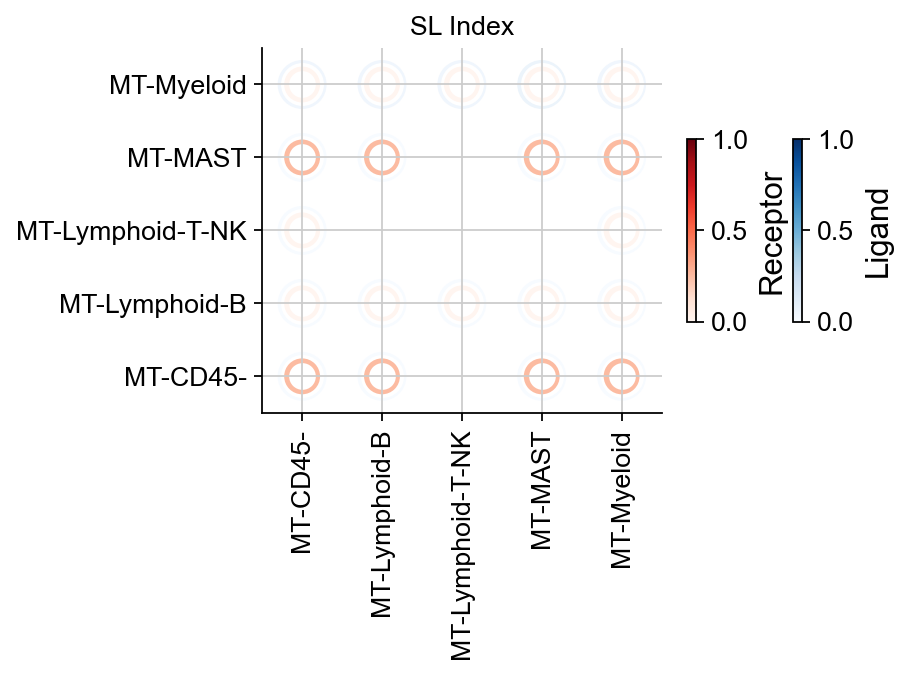

In [23]:
#c=kegg_result_ad['num'],cmap='Greens'

fig, ax = plt.subplots(figsize=(5,3))


plt.scatter(range(5),[0]*5,s=400,c=plot_data1['MT-CD45-'],cmap='Blues',linewidth=2,vmax=1,vmin=0)
plt.scatter(range(5),[1]*5,s=400,c=plot_data1['MT-Lymphoid-B'],cmap='Blues',linewidth=2,vmax=1,vmin=0)
plt.scatter(range(5),[2]*5,s=400,c=plot_data1['MT-Lymphoid-T-NK'],cmap='Blues',linewidth=2,vmax=1,vmin=0)
plt.scatter(range(5),[3]*5,s=400,c=plot_data1['MT-MAST'],cmap='Blues',linewidth=2,vmax=1,vmin=0)
plt.scatter(range(5),[4]*5,s=400,c=plot_data1['MT-Myeloid'],cmap='Blues',linewidth=2,vmax=1,vmin=0)


#position=pp.add_axes([1, 0.05, 0.7, 0.03])#位置[左,下,右,上]
cb=plt.colorbar(label="Ligand",shrink=0.5) 
cb.ax.tick_params(labelsize=12)

plt.scatter(range(5),[0]*5,s=300,color='w', edgecolors='w',linewidth=2)
plt.scatter(range(5),[1]*5,s=300,color='w', edgecolors='w',linewidth=2)
plt.scatter(range(5),[2]*5,s=300,color='w', edgecolors='w',linewidth=2)
plt.scatter(range(5),[3]*5,s=300,color='w', edgecolors='w',linewidth=2)
plt.scatter(range(5),[4]*5,s=300,color='w', edgecolors='w',linewidth=2)

plt.scatter(range(5),[0]*5,s=200,c=plot_data2['MT-CD45-'],cmap='Reds',linewidth=2,vmax=1,vmin=0)
plt.scatter(range(5),[1]*5,s=200,c=plot_data2['MT-Lymphoid-B'],cmap='Reds',linewidth=2,vmax=1,vmin=0)
plt.scatter(range(5),[2]*5,s=200,c=plot_data2['MT-Lymphoid-T-NK'],cmap='Reds',linewidth=2,vmax=1,vmin=0)
plt.scatter(range(5),[3]*5,s=200,c=plot_data2['MT-MAST'],cmap='Reds',linewidth=2,vmax=1,vmin=0)
plt.scatter(range(5),[4]*5,s=200,c=plot_data2['MT-Myeloid'],cmap='Reds',linewidth=2,vmax=1,vmin=0)

cb=plt.colorbar(label="Receptor",shrink=0.5) 
cb.ax.tick_params(labelsize=12)

plt.scatter(range(5),[0]*5,s=100,color='w', edgecolors='w',linewidth=2)
plt.scatter(range(5),[1]*5,s=100,color='w', edgecolors='w',linewidth=2)
plt.scatter(range(5),[2]*5,s=100,color='w', edgecolors='w',linewidth=2)
plt.scatter(range(5),[3]*5,s=100,color='w', edgecolors='w',linewidth=2)
plt.scatter(range(5),[4]*5,s=100,color='w', edgecolors='w',linewidth=2)

plt.xticks(range(5),de.columns[6:11].tolist(),rotation=90,fontsize=12)
plt.yticks(range(5),de.columns[6:11].tolist(),fontsize=12)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.xlim(-0.5,4.5)
plt.ylim(-0.5,4.5)
plt.title('SL Index',fontsize=12)
plt.savefig("result/fig2-mt-sl.png",dpi=300,bbox_inches = 'tight')

In [24]:
pvalue=pd.read_csv('content/out/pvalues.txt',sep='\t')
pvalue.set_index(pvalue.columns[1],inplace=True)
p=pvalue.loc[:,~pvalue.columns.str.contains('PT')]
p.head()

id_cp_interaction       partner_a      partner_b    gene_a  \
interacting_pair                                                              
KLRG2_WNT11        CPI-SS0A7B487D4   simple:A4D1S0  simple:O96014     KLRG2   
KLRG2_TNFSF9       CPI-SS0FEC87269   simple:A4D1S0  simple:P41273     KLRG2   
HLA-DPA1_TNFSF9    CPI-SS028784FC6  simple:HLADPA1  simple:P41273  HLA-DPA1   
PVR_TNFSF9         CPI-SS00A8596B5   simple:P15151  simple:P41273       PVR   
KLRG2_WNT5B        CPI-SS044DF8749   simple:A4D1S0  simple:Q9H1J7     KLRG2   

                  gene_b  secreted  receptor_a  receptor_b  \
interacting_pair                                             
KLRG2_WNT11        WNT11      True        True       False   
KLRG2_TNFSF9      TNFSF9      True        True       False   
HLA-DPA1_TNFSF9   TNFSF9      True        True       False   
PVR_TNFSF9        TNFSF9      True        True       False   
KLRG2_WNT5B        WNT5B      True        True       False   

                 annotation_strategy  is_integrin  ...  MT-MAST|MT-CD45-  \
interacting_pair                                   ...                     
KLRG2_WNT11             InnateDB-All        False  ...               1.0   
KLRG2_TNFSF9            InnateDB-All        False  ...               1.0   
HLA-DPA1_TNFSF9         InnateDB-All        False  ...               1.0   
PVR_TNFSF9              InnateDB-All        False  ...               1.0   
KLRG2_WNT5B             InnateDB-All        False  ...               1.0   

                  MT-MAST|MT-Lymphoid-B  MT-MAST|MT-Lymphoid-T-NK  \
interacting_pair                                                    
KLRG2_WNT11                         1.0                       1.0   
KLRG2_TNFSF9                        1.0                       1.0   
HLA-DPA1_TNFSF9                     1.0                       1.0   
PVR_TNFSF9                          1.0                       1.0   
KLRG2_WNT5B                         1.0                       1.0   

                  MT-MAST|MT-MAST  MT-MAST|MT-Myeloid  MT-Myeloid|MT-CD45-  \
interacting_pair                                                             
KLRG2_WNT11                   1.0                 1.0                  1.0   
KLRG2_TNFSF9                  1.0                 1.0                  1.0   
HLA-DPA1_TNFSF9               1.0                 1.0                  1.0   
PVR_TNFSF9                    1.0                 1.0                  1.0   
KLRG2_WNT5B                   1.0                 1.0                  1.0   

                  MT-Myeloid|MT-Lymphoid-B  MT-Myeloid|MT-Lymphoid-T-NK  \
interacting_pair                                                          
KLRG2_WNT11                            1.0                          1.0   
KLRG2_TNFSF9                           1.0                          1.0   
HLA-DPA1_TNFSF9                        0.0                          1.0   
PVR_TNFSF9                             1.0                          1.0   
KLRG2_WNT5B                            1.0                          1.0   

                  MT-Myeloid|MT-MAST  MT-Myeloid|MT-Myeloid  
interacting_pair                                             
KLRG2_WNT11                      1.0                    1.0  
KLRG2_TNFSF9                     1.0                    1.0  
HLA-DPA1_TNFSF9                  1.0                    1.0  
PVR_TNFSF9                       1.0                    1.0  
KLRG2_WNT5B                      1.0                    1.0  

[5 rows x 35 columns]

In [25]:
exp=sig_means1.loc[:,~sig_means1.columns.str.contains('PT')]
exp.head()

id_cp_interaction                  partner_a  \
interacting_pair                                                        
PlexinA2_complex1_SEMA3A   CPI-CS0D238C22B  complex:PlexinA2_complex1   
COL4A5_a11b1 complex       CPI-SC0CE433AB8              simple:P29400   
COL8A1_a11b1 complex       CPI-SC08CC68F11              simple:P27658   
COL5A3_a11b1 complex       CPI-SC07E958BDE              simple:P25940   
FGFR1_NCAM1                CPI-SS039799099              simple:P11362   

                                      partner_b  gene_a  gene_b  secreted  \
interacting_pair                                                            
PlexinA2_complex1_SEMA3A          simple:Q14563     NaN  SEMA3A      True   
COL4A5_a11b1 complex      complex:a11b1 complex  COL4A5     NaN      True   
COL8A1_a11b1 complex      complex:a11b1 complex  COL8A1     NaN      True   
COL5A3_a11b1 complex      complex:a11b1 complex  COL5A3     NaN      True   
FGFR1_NCAM1                       simple:P13591   FGFR1   NCAM1      True   

                          receptor_a  receptor_b annotation_strategy  \
interacting_pair                                                       
PlexinA2_complex1_SEMA3A        True       False             curated   
COL4A5_a11b1 complex           False       False             curated   
COL8A1_a11b1 complex           False       False             curated   
COL5A3_a11b1 complex           False       False             curated   
FGFR1_NCAM1                     True        True             curated   

                          is_integrin  ...  MT-MAST|MT-CD45-  \
interacting_pair                       ...                     
PlexinA2_complex1_SEMA3A        False  ...               NaN   
COL4A5_a11b1 complex             True  ...               NaN   
COL8A1_a11b1 complex             True  ...               NaN   
COL5A3_a11b1 complex             True  ...               NaN   
FGFR1_NCAM1                     False  ...               NaN   

                          MT-MAST|MT-Lymphoid-B  MT-MAST|MT-Lymphoid-T-NK  \
interacting_pair                                                            
PlexinA2_complex1_SEMA3A                    NaN                       NaN   
COL4A5_a11b1 complex                        NaN                       NaN   
COL8A1_a11b1 complex                        NaN                       NaN   
COL5A3_a11b1 complex                        NaN                       NaN   
FGFR1_NCAM1                                 NaN                       NaN   

                          MT-MAST|MT-MAST  MT-MAST|MT-Myeloid  \
interacting_pair                                                
PlexinA2_complex1_SEMA3A              NaN                 NaN   
COL4A5_a11b1 complex                  NaN                 NaN   
COL8A1_a11b1 complex                  NaN                 NaN   
COL5A3_a11b1 complex                  NaN                 NaN   
FGFR1_NCAM1                           NaN                 NaN   

                          MT-Myeloid|MT-CD45-  MT-Myeloid|MT-Lymphoid-B  \
interacting_pair                                                          
PlexinA2_complex1_SEMA3A                  NaN                       NaN   
COL4A5_a11b1 complex                      NaN                       NaN   
COL8A1_a11b1 complex                      NaN                       NaN   
COL5A3_a11b1 complex                      NaN                       NaN   
FGFR1_NCAM1                               NaN                       NaN   

                          MT-Myeloid|MT-Lymphoid-T-NK  MT-Myeloid|MT-MAST  \
interacting_pair                                                            
PlexinA2_complex1_SEMA3A                          NaN                 NaN   
COL4A5_a11b1 complex                              NaN                 NaN   
COL8A1_a11b1 complex                              NaN                 NaN   
COL5A3_a11b1 complex                              NaN                 NaN   
FGFR1_NCAM1                        

In [26]:
def find_pt_mt():
    test=exp.loc[:,exp.columns.str.contains('\|MT-')]
    test1=test.loc[:,~test.columns.str.contains('PT-')]
    return test1.columns.tolist()

In [27]:
plot_data3=pd.DataFrame(columns=['Pair','means','p-value','Type'])
p_pair=find_pt_mt()
res2=[i.replace('-','_') for i in res1]
for i in list(set(res2)):
    #i=i.replace('-','_')
    plot_data4=pd.DataFrame()
    plot_data4['Pair']=[j for j in [i]*len(p_pair)]
    plot_data4['means']=exp.loc[i,p_pair].values
    plot_data4['p-value']=-np.log10(p.loc[i,p_pair].values.tolist())+0.3
    plot_data4['Type']=p_pair
    
    plot_data3=pd.concat([plot_data3,plot_data4])
plot_data3=plot_data3.fillna(0)

plot_data3['means']=np.log2(plot_data3['means'])
plot_data3=plot_data3.replace(float('inf'),3)
plot_data3=plot_data3.replace(float('-inf'),-3)
plot_data3.head()

/var/folders/4m/2xw3_2s503s9r616083n7w440000gn/T/ipykernel_787/3299246447.py:9: RuntimeWarning: divide by zero encountered in log10
  plot_data4['p-value']=-np.log10(p.loc[i,p_pair].values.tolist())+0.3
/var/folders/4m/2xw3_2s503s9r616083n7w440000gn/T/ipykernel_787/3299246447.py:9: RuntimeWarning: divide by zero encountered in log10
  plot_data4['p-value']=-np.log10(p.loc[i,p_pair].values.tolist())+0.3
/var/folders/4m/2xw3_2s503s9r616083n7w440000gn/T/ipykernel_787/3299246447.py:9: RuntimeWarning: divide by zero encountered in log10
  plot_data4['p-value']=-np.log10(p.loc[i,p_pair].values.tolist())+0.3
/var/folders/4m/2xw3_2s503s9r616083n7w440000gn/T/ipykernel_787/3299246447.py:9: RuntimeWarning: divide by zero encountered in log10
  plot_data4['p-value']=-np.log10(p.loc[i,p_pair].values.tolist())+0.3
/var/folders/4m/2xw3_2s503s9r616083n7w440000gn/T/ipykernel_787/3299246447.py:9: RuntimeWarning: divide by zero encountered in log10
  plot_data4['p-value']=-np.log10(p.loc[i,p_pair].values

Pair  means  p-value                       Type
0  CD74_MIF   -3.0  0.30000          MT-CD45-|MT-CD45-
1  CD74_MIF   -3.0  0.30000     MT-CD45-|MT-Lymphoid-B
2  CD74_MIF   -3.0  0.30000  MT-CD45-|MT-Lymphoid-T-NK
3  CD74_MIF   -3.0  0.36956           MT-CD45-|MT-MAST
4  CD74_MIF   -3.0  0.30000        MT-CD45-|MT-Myeloid

[Text(0, 1, 'EGFR_COPA'),
 Text(0, 2, 'EGFR_MIF'),
 Text(0, 3, 'NTRK1_GPI'),
 Text(0, 4, 'CD55_ADGRE5'),
 Text(0, 5, 'SPP1_CD44'),
 Text(0, 6, 'JAG1_NOTCH2'),
 Text(0, 7, 'CD74_COPA'),
 Text(0, 8, 'NTRK1_NAMPT'),
 Text(0, 9, 'C5AR1_RPS19'),
 Text(0, 10, 'NTRK1_COPA'),
 Text(0, 11, 'CD74_MIF')]

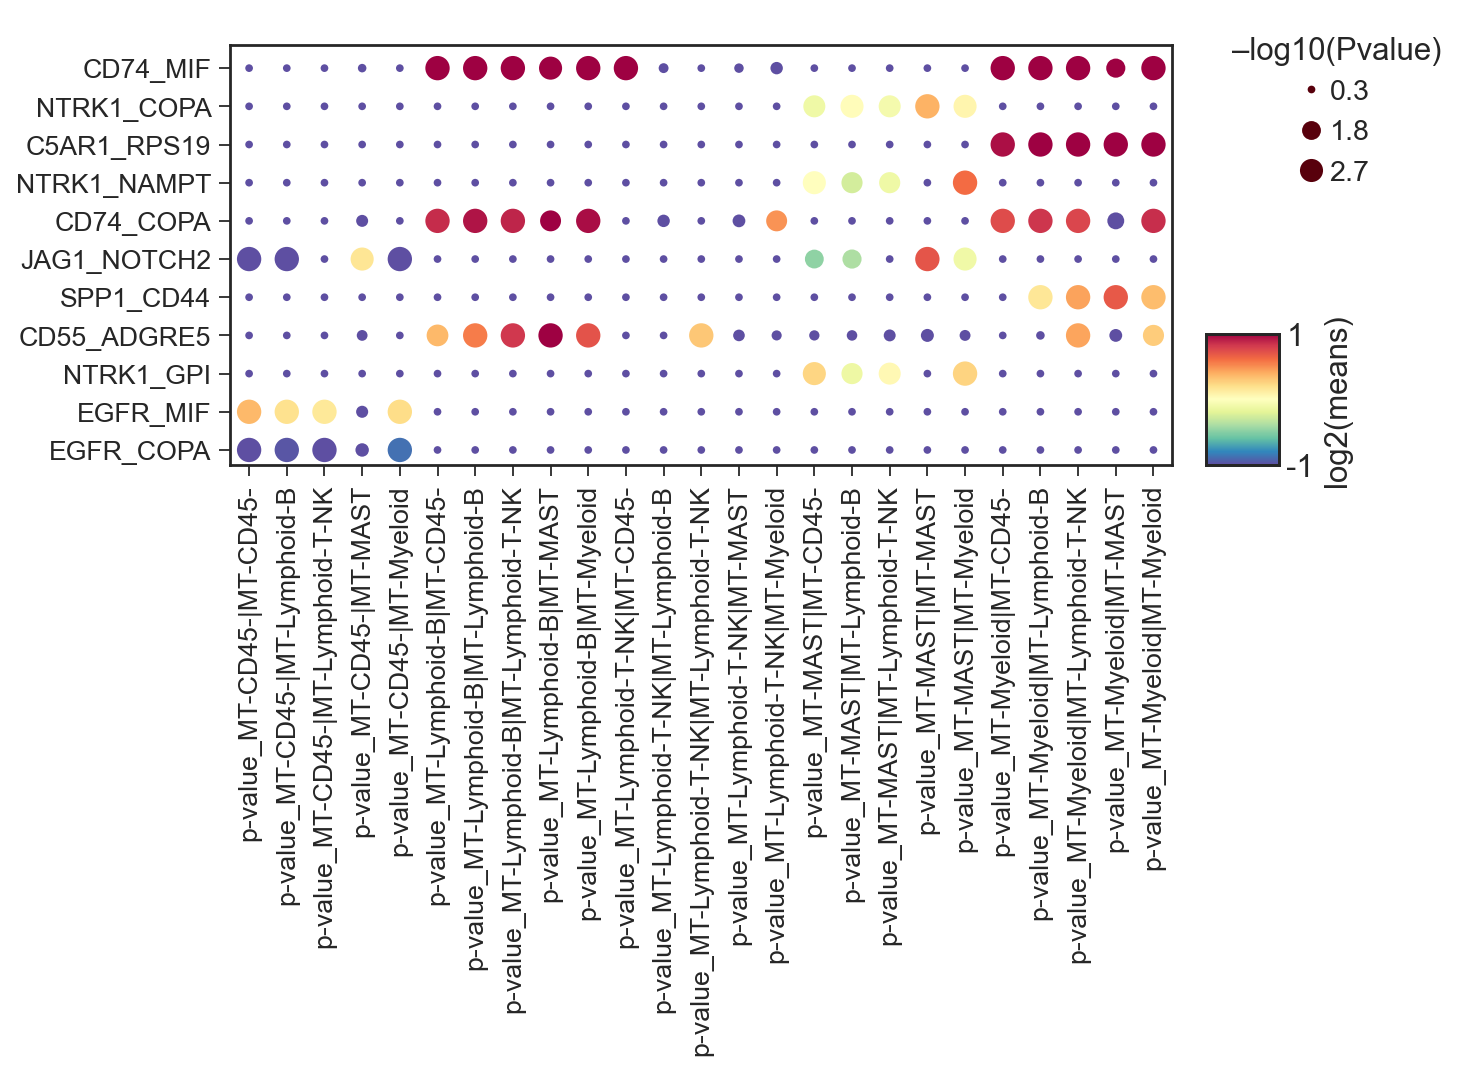

In [28]:
import dotplot
new_keys = {'item_key': 'Pair','group_key': 'Type','sizes_key': 'p-value','color_key': 'means'}
dp = dotplot.DotPlot.parse_from_tidy_data(plot_data3, **new_keys)
ax = dp.plot(size_factor=40, cmap='Spectral_r',
             dot_title = '–log10(Pvalue)', colorbar_title = 'log2(means)',vmin=-1,vmax=1)

xlabs=ax.get_axes()[0].get_xticklabels()
ax.get_axes()[0].set_xticklabels(xlabs,fontsize=12)
ylabs=ax.get_axes()[0].get_yticklabels()
ax.get_axes()[0].set_yticklabels(ylabs,fontsize=12)

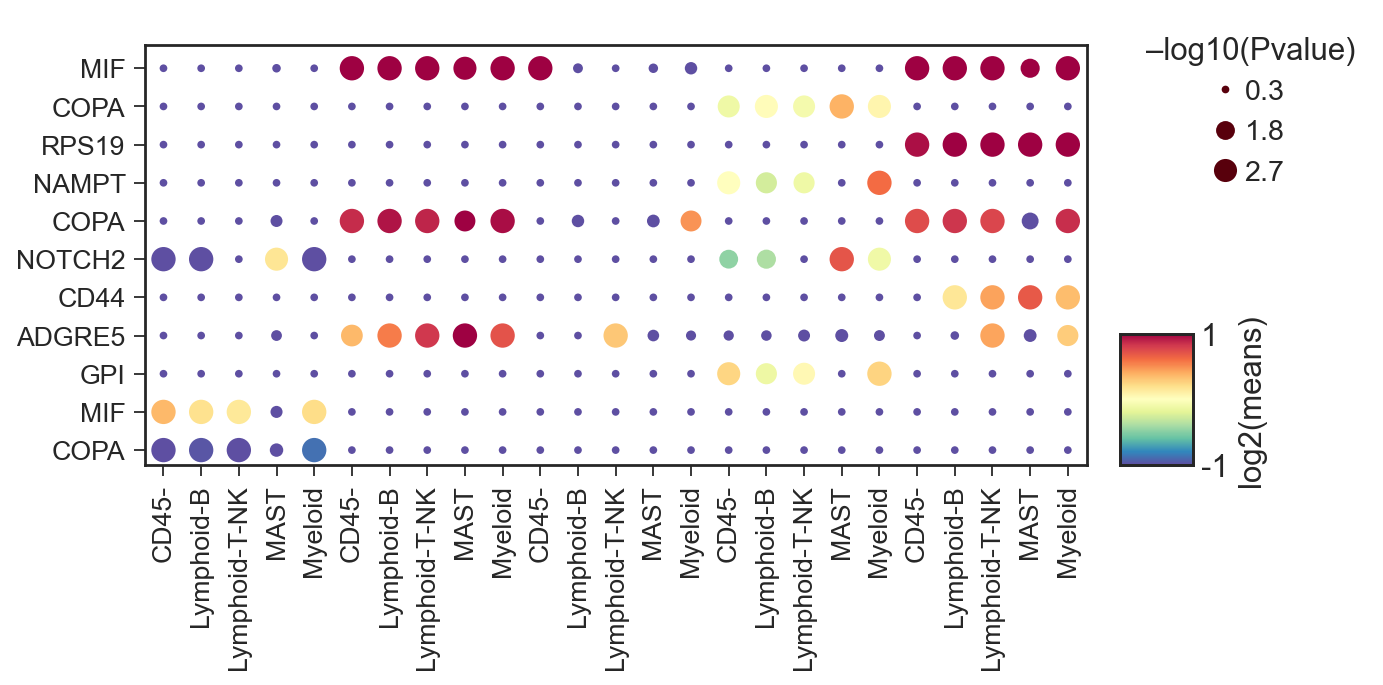

In [29]:
[i.set_text(i.get_text().split('|')[1].replace('MT-','')) for i in xlabs]
ax.get_axes()[0].set_xticklabels(xlabs,fontsize=12)

[i.set_text(i.get_text().split('_')[1]) for i in ylabs]
ax.get_axes()[0].set_yticklabels(ylabs,fontsize=12)
ax

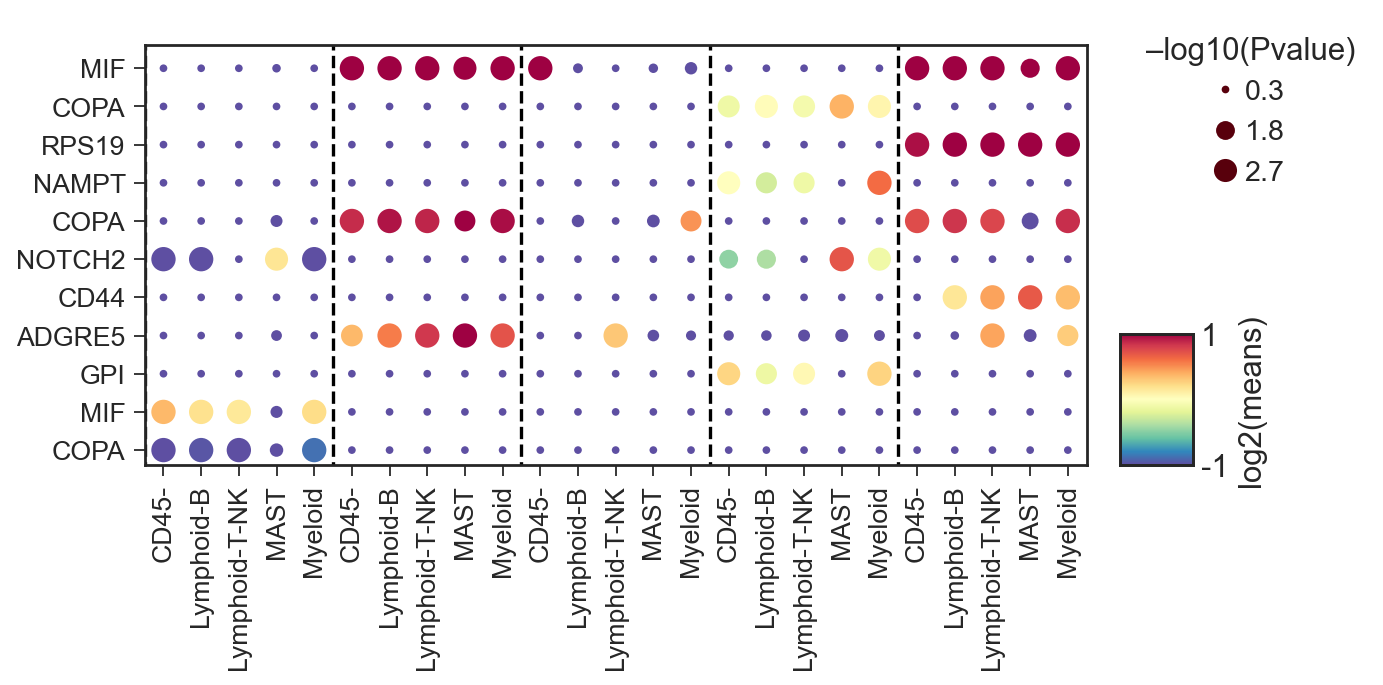

In [30]:
for i in range(len(xlabs)):
    if i%5==0:
        ax.get_axes()[0].axvline(x=i+0.5, ymin=-1, ymax=10,color='black',linestyle="--")
ax

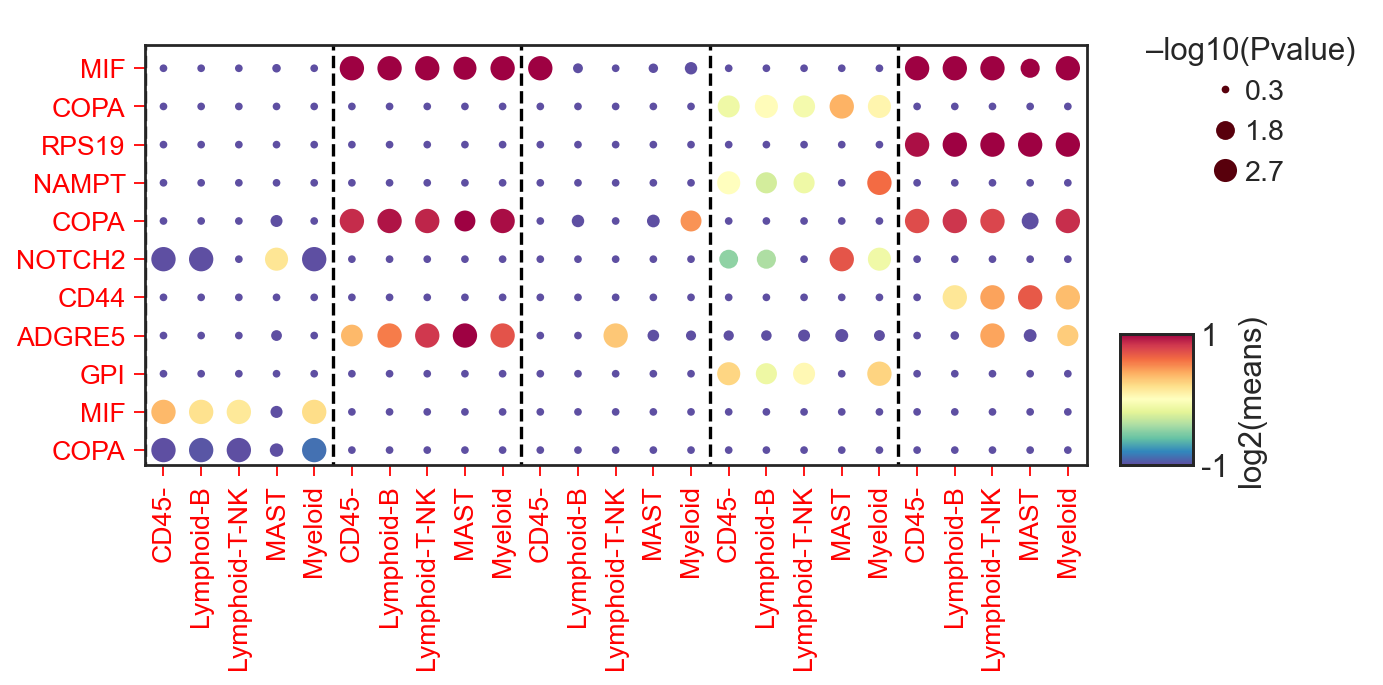

In [31]:
ax.get_axes()[0].tick_params(axis='both',colors='red', which='both')
ax.savefig("result/figure3B_MT_receptor.png",dpi=300,bbox_inches = 'tight')
ax

[Text(0, 1, 'EGFR_COPA'),
 Text(0, 2, 'EGFR_MIF'),
 Text(0, 3, 'NTRK1_GPI'),
 Text(0, 4, 'CD55_ADGRE5'),
 Text(0, 5, 'SPP1_CD44'),
 Text(0, 6, 'JAG1_NOTCH2'),
 Text(0, 7, 'CD74_COPA'),
 Text(0, 8, 'NTRK1_NAMPT'),
 Text(0, 9, 'C5AR1_RPS19'),
 Text(0, 10, 'NTRK1_COPA'),
 Text(0, 11, 'CD74_MIF')]

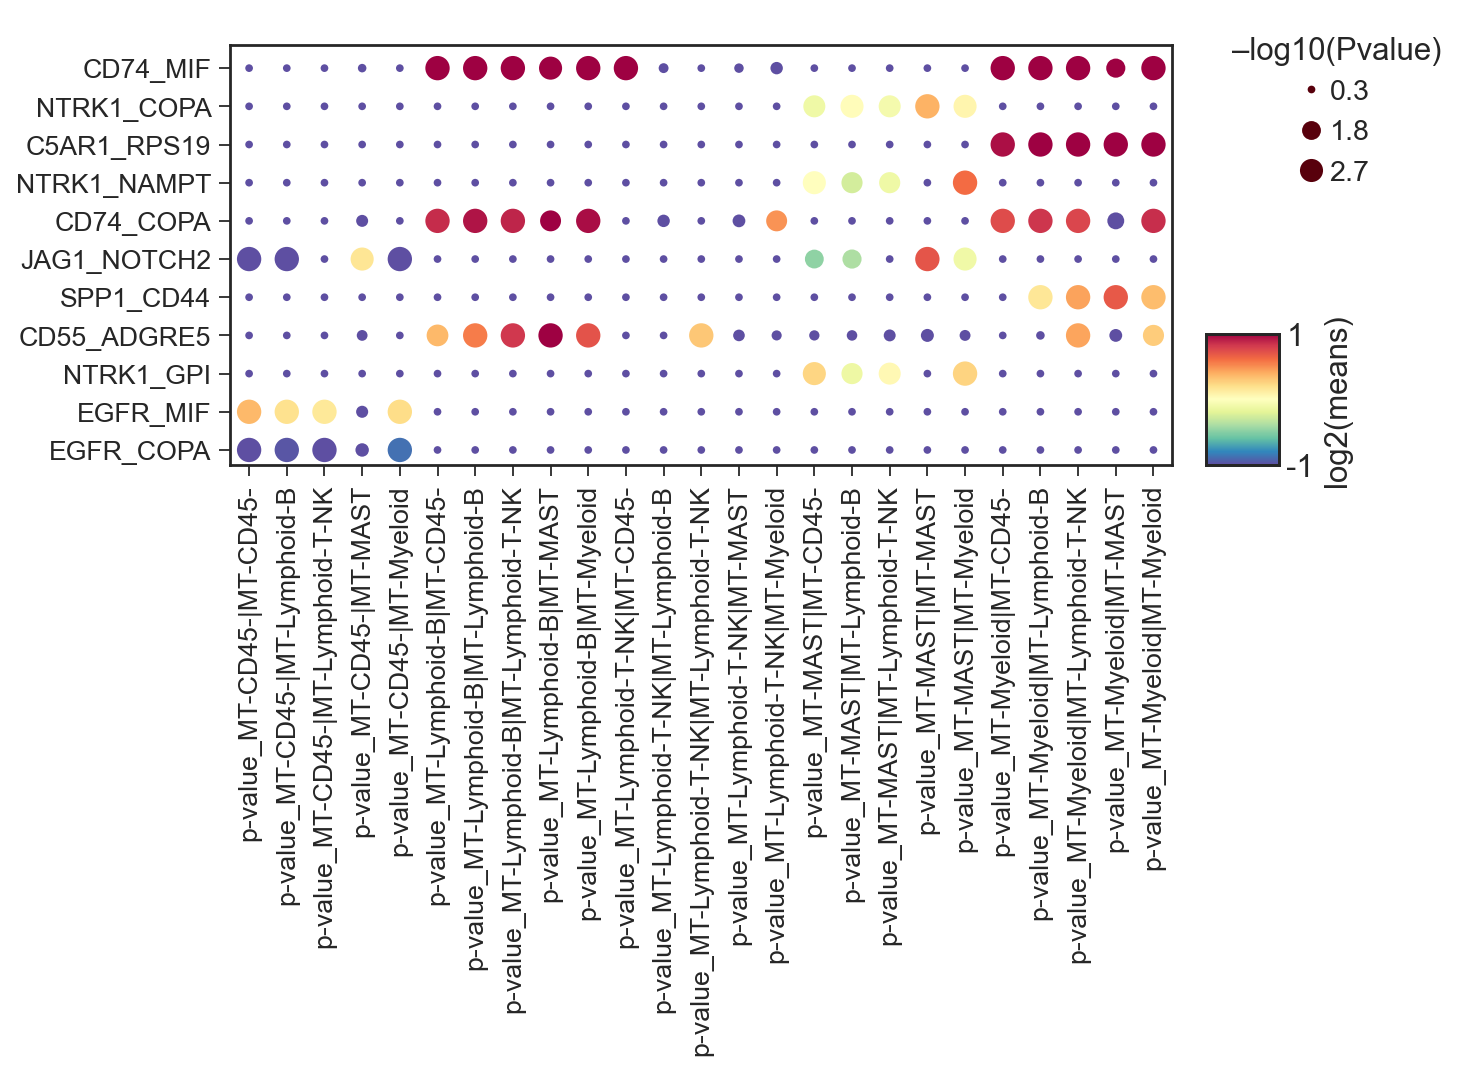

In [32]:

new_keys = {'item_key': 'Pair','group_key': 'Type','sizes_key': 'p-value','color_key': 'means'}
dp = dotplot.DotPlot.parse_from_tidy_data(plot_data3, **new_keys)
ax = dp.plot(size_factor=40, cmap='Spectral_r',
             dot_title = '–log10(Pvalue)', colorbar_title = 'log2(means)',vmin=-1,vmax=1)

xlabs=ax.get_axes()[0].get_xticklabels()
ax.get_axes()[0].set_xticklabels(xlabs,fontsize=12)
ylabs=ax.get_axes()[0].get_yticklabels()
ax.get_axes()[0].set_yticklabels(ylabs,fontsize=12)

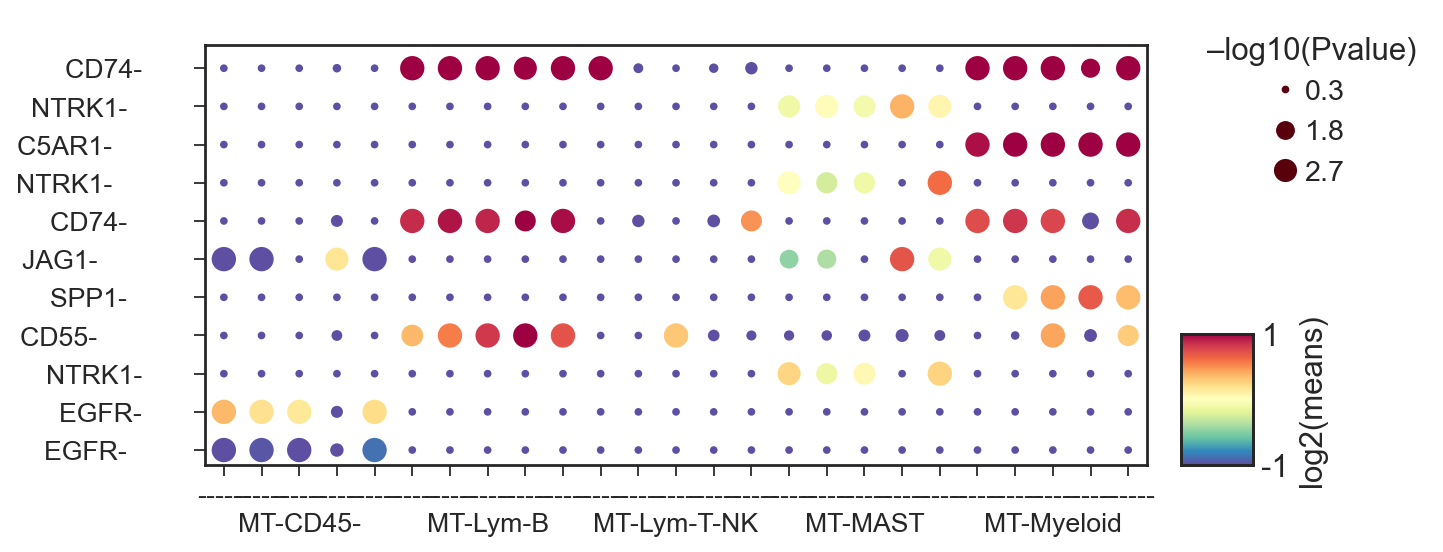

In [33]:
[xlabs[i].set_text('------') for i in range(len(xlabs)) if (i+3)%5!=0]
[xlabs[i].set_text('------\n'+xlabs[i].get_text().replace('p-value_','').replace('Lymphoid','Lym').split('|')[0]) for i in range(len(xlabs)) if (i+3)%5==0]
ax.get_axes()[0].set_xticklabels(xlabs,fontsize=12,rotation=0)

[i.set_text(i.get_text().split('_')[0]+'-'+'  '*len(i.get_text().split('_')[1])) for i in ylabs]
ax.get_axes()[0].set_yticklabels(ylabs,fontsize=12)
ax

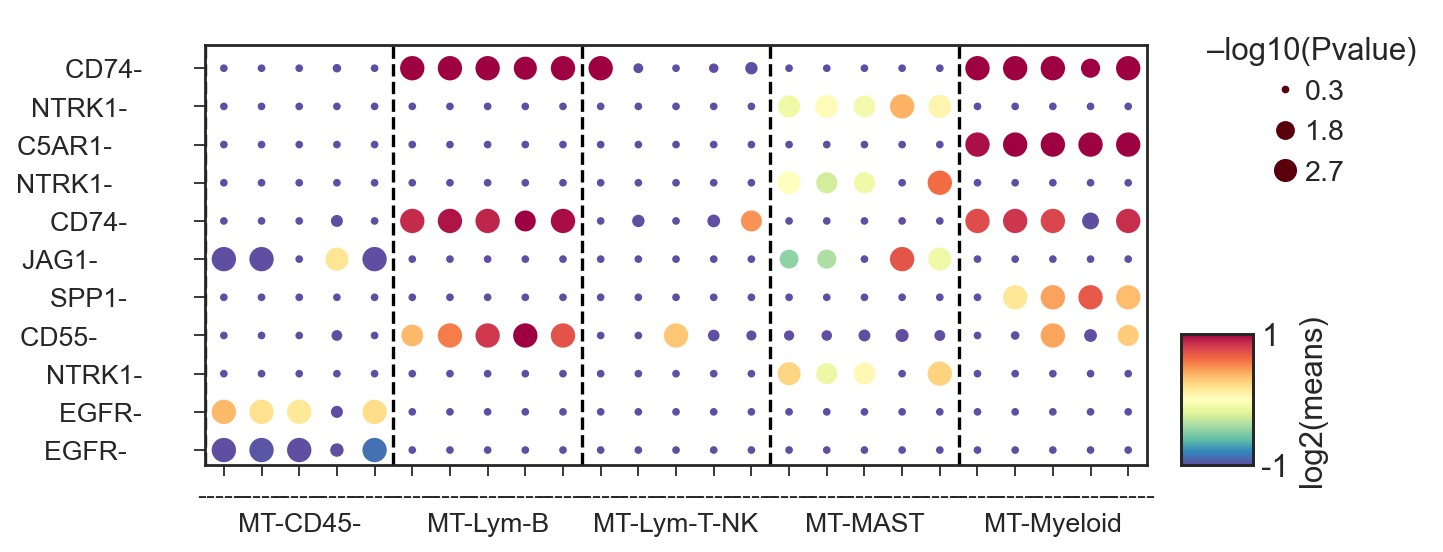

In [34]:
for i in range(len(xlabs)):
    if i%5==0:
        ax.get_axes()[0].axvline(x=i+0.5, ymin=-1, ymax=10,color='black',linestyle="--")
ax

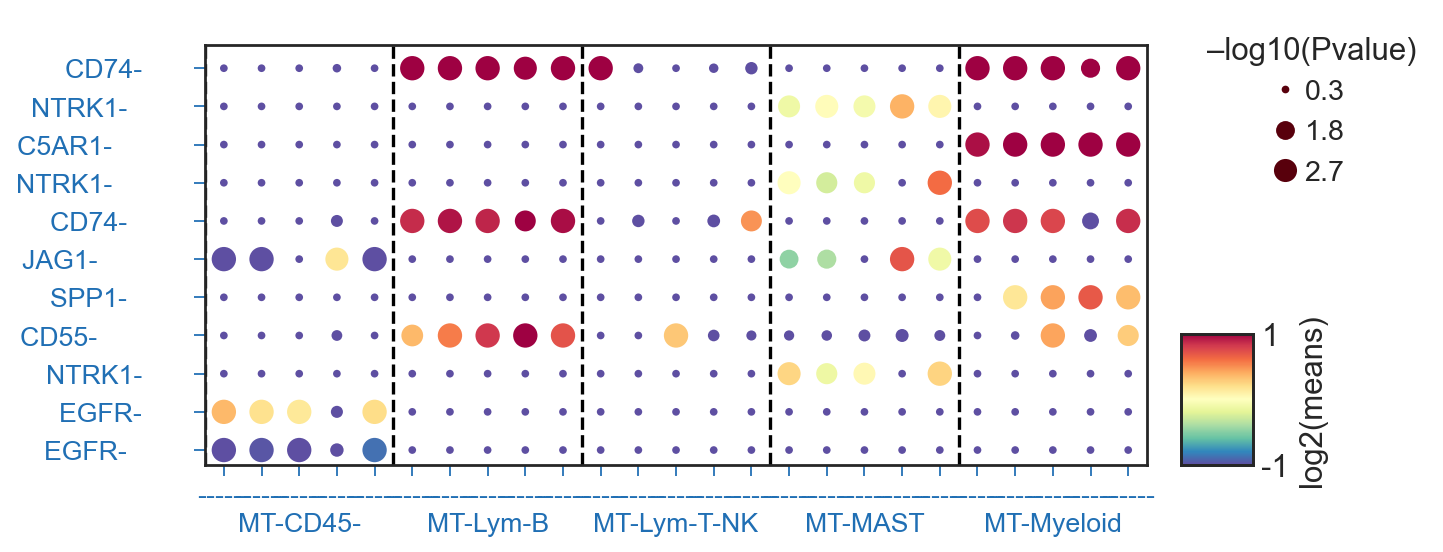

In [35]:
ax.get_axes()[0].tick_params(axis='both',colors='#206FB4', which='major')
ax.savefig("result/figure3B_MT-ligand.png",dpi=300,bbox_inches = 'tight')
ax

# PT

In [36]:
de.columns[11:]

Index(['PT-CD45-', 'PT-Lymphoid-B', 'PT-Lymphoid-T-NK', 'PT-MAST',
       'PT-Myeloid'],
      dtype='object')

In [37]:
G=nx.Graph()
for name in de.columns[11:]:
    test=sig_means.loc[:,sig_means.columns.str.contains(name+'\|PT')].sum()
    for i in test.index:
        if test.loc[i]!=0:
            a=i.split('|')
            G.add_edge(a[0],a[1],weight=test.loc[i])

In [38]:
G.edges

EdgeView([('PT-CD45-', 'PT-CD45-'), ('PT-CD45-', 'PT-Lymphoid-B'), ('PT-CD45-', 'PT-Lymphoid-T-NK'), ('PT-CD45-', 'PT-MAST'), ('PT-CD45-', 'PT-Myeloid'), ('PT-Lymphoid-B', 'PT-Lymphoid-B'), ('PT-Lymphoid-B', 'PT-Lymphoid-T-NK'), ('PT-Lymphoid-B', 'PT-MAST'), ('PT-Lymphoid-B', 'PT-Myeloid'), ('PT-Lymphoid-T-NK', 'PT-Lymphoid-T-NK'), ('PT-Lymphoid-T-NK', 'PT-MAST'), ('PT-Lymphoid-T-NK', 'PT-Myeloid'), ('PT-MAST', 'PT-MAST'), ('PT-MAST', 'PT-Myeloid'), ('PT-Myeloid', 'PT-Myeloid')])

In [39]:
categories=[]
dv_colors=['red']
n=0
for i in ['PT']:
    info_dict={
                "name": i,
                "itemStyle": {
                    "normal": {
                        "color": dv_colors[n],
                        "borderColor":dv_colors[n],
                        "borderWidth":1.8
                    }
                }
            }
    categories.append(info_dict)
    n+=1

In [40]:
from pyecharts.render import make_snapshot
from snapshot_selenium import snapshot

In [41]:
#!pip install pyecharts
from pyecharts import options as opts
from pyecharts.charts import Graph
nodes=[]
G_degree=dict(G.degree(G.nodes()))


G_nodes_dict={}
links = []
for i in G.edges:
    if i[0] not in G_nodes_dict.keys():
        G_nodes_dict[i[0]]=0
    if i[1] not in G_nodes_dict.keys():
        G_nodes_dict[i[1]]=0
    links.append({"source": i[0], "target": i[1]})
    weight=G.get_edge_data(i[0],i[1])['weight']
    G_nodes_dict[i[0]]+=weight
    G_nodes_dict[i[1]]+=weight

for i in G.nodes:
    no={}
    no['name']=i
    no['symbolSize']=G_nodes_dict[i]/5
    ca=i.split('-')[0]
    no['category']=ca
    nodes.append(no)

c = (
    Graph(init_opts=opts.InitOpts(#bg_color='rgba(255,250,205,0.2)',
                                width='400px', \
                                height='400px', \
                                page_title='page', \
                                ))
    
    .add("", nodes, links,
         categories = categories,
         is_draggable=True,
         gravity=0.1,
         #is_roam= True,
         #layout='circular',
          #graph_layout="force",
          repulsion=1000,
          #graph_edge_symbol=['cricle'],
          
        )
    .set_global_opts(title_opts=opts.TitleOpts(title="CRLM"))
    .render("result/pt_graph.html")
)
#make_snapshot(snapshot, c.render(), "ctrl_network.png")

In [42]:
sig_means1=sig_means.copy()
sig_means1.set_index(sig_means1.columns[1],inplace=True)
sig_means1.head()


id_cp_interaction                  partner_a  \
interacting_pair                                                        
PlexinA2_complex1_SEMA3A   CPI-CS0D238C22B  complex:PlexinA2_complex1   
COL4A5_a11b1 complex       CPI-SC0CE433AB8              simple:P29400   
COL8A1_a11b1 complex       CPI-SC08CC68F11              simple:P27658   
COL5A3_a11b1 complex       CPI-SC07E958BDE              simple:P25940   
FGFR1_NCAM1                CPI-SS039799099              simple:P11362   

                                      partner_b  gene_a  gene_b  secreted  \
interacting_pair                                                            
PlexinA2_complex1_SEMA3A          simple:Q14563     NaN  SEMA3A      True   
COL4A5_a11b1 complex      complex:a11b1 complex  COL4A5     NaN      True   
COL8A1_a11b1 complex      complex:a11b1 complex  COL8A1     NaN      True   
COL5A3_a11b1 complex      complex:a11b1 complex  COL5A3     NaN      True   
FGFR1_NCAM1                       simple:P13591   FGFR1   NCAM1      True   

                          receptor_a  receptor_b annotation_strategy  \
interacting_pair                                                       
PlexinA2_complex1_SEMA3A        True       False             curated   
COL4A5_a11b1 complex           False       False             curated   
COL8A1_a11b1 complex           False       False             curated   
COL5A3_a11b1 complex           False       False             curated   
FGFR1_NCAM1                     True        True             curated   

                          is_integrin  ...  PT-Myeloid|MT-CD45-  \
interacting_pair                       ...                        
PlexinA2_complex1_SEMA3A        False  ...                  NaN   
COL4A5_a11b1 complex             True  ...                  NaN   
COL8A1_a11b1 complex             True  ...                  NaN   
COL5A3_a11b1 complex             True  ...                  NaN   
FGFR1_NCAM1                     False  ...                  NaN   

                          PT-Myeloid|MT-Lymphoid-B  \
interacting_pair                                     
PlexinA2_complex1_SEMA3A                       NaN   
COL4A5_a11b1 complex                           NaN   
COL8A1_a11b1 complex                           NaN   
COL5A3_a11b1 complex                           NaN   
FGFR1_NCAM1                                    NaN   

                          PT-Myeloid|MT-Lymphoid-T-NK  PT-Myeloid|MT-MAST  \
interacting_pair                                                            
PlexinA2_complex1_SEMA3A                          NaN                 NaN   
COL4A5_a11b1 complex                              NaN                 NaN   
COL8A1_a11b1 complex                              NaN                 NaN   
COL5A3_a11b1 complex                              NaN                 NaN   
FGFR1_NCAM1                                       NaN                 NaN   

                          PT-Myeloid|MT-Myeloid  PT-Myeloid|PT-CD45-  \
interacting_pair                                                       
PlexinA2_complex1_SEMA3A                    NaN                  NaN   
COL4A5_a11b1 complex                        NaN                  NaN   
COL8A1_a11b1 complex                        NaN                  NaN   
COL5A3_a11b1 complex                        NaN                  NaN   
FGFR1_NCAM1                                 NaN                  NaN   

                          PT-Myeloid|PT-Lymphoid-B  \
interacting_pair                                     
PlexinA2_complex1_SEMA3A                       NaN   
COL4A5_a11b1 complex                           NaN   
COL8A1_a11b1 complex                           NaN   
COL5A3_a11b1 complex                           NaN   
FGFR1_NCAM1                                    NaN   

                          PT-Myeloid|PT-Lymphoid-T-NK  PT-Myeloid|PT-MAST  \
interacting_pair                                                            
PlexinA2_complex1_SEMA3A                 

In [43]:
def find_interaction(name):
    test=sig_means1.loc[:,sig_means1.columns.str.contains(name+'\|PT')]
    #test=sig_means1.loc[:,sig_means1.columns.str.contains(name+'\|MT')]
    test1=test.loc[test.sum(axis=1)!=0].isnull().sum(axis=1).sort_values()
    res=test.loc[test1[(test1<=1)].index].index.tolist()
    return res

In [44]:
res=[]
for i in de.columns[11:]:
    res+=find_interaction(i)
res

['ICAM1_AREG',
 'TNFSF10_RIPK1',
 'MDK_SORL1',
 'EGFR_COPA',
 'LGALS9_SLC1A5',
 'TNFRSF10B_TNFSF10',
 'FN1_a4b1 complex',
 'EGFR_AREG',
 'LGALS9_CD47',
 'LAMP1_FAM3C',
 'DLL1_NOTCH2',
 'FN1_a5b1 complex',
 'ADORA2B_ENTPD1',
 'PLXNB2_SEMA4D',
 'EGFR_TGFB1',
 'FN1_a4b7 complex',
 'FBN1_a5b1 complex',
 'EGFR_GRN',
 'EGFR_MIF',
 'VCAM1_a4b7 complex',
 'IGF2_IGF2R',
 'CDH1_aEb7 complex',
 'HGF_CD44',
 'LGALS9_CD44',
 'LGALS9_SORL1',
 'TNFRSF1A_GRN',
 'ICAM1_SPN',
 'IGF2_IDE',
 'JAG1_NOTCH2',
 'CD74_MIF',
 'HLA-C_FAM3C',
 'CD74_COPA',
 'HLA-DPA1_TNFSF9',
 'MIF_TNFRSF14',
 'ADORA2A_ENTPD1',
 'ADORA2A_NAMPT',
 'PECAM1_CD38',
 'CD55_ADGRE5',
 'CD2_CD58',
 'IFNG_Type II IFNR',
 'PDCD1_FAM3C',
 'CD74_COPA',
 'TNFRSF1B_GRN',
 'TNFRSF1A_GRN',
 'ICAM1_AREG',
 'NTRK1_NAMPT',
 'NTRK1_GPI',
 'NTRK1_COPA',
 'TNFSF10_RIPK1',
 'PLAUR_a4b1 complex',
 'NTRK1_AIMP1',
 'ADORA1_ENTPD1',
 'ALOX5_ALOX5AP',
 'NTRK1_GRN',
 'ICAM1_SPN',
 'ADORA3_ENTPD1',
 'ICAM1_AREG',
 'PLAUR_a4b1 complex',
 'TNF_RIPK1',
 'C5AR1_R

In [45]:
res1=[]
for i in res:
    a=i.split('_')
    if a[0] in SL_pair['gene1'].tolist():
        if a[1] in SL_pair['gene2'].tolist():
            if a[1]=='BMPR2':
                print(i,a[0],a[1])
                continue
            res1.append(a[0]+'_'+a[1])
    elif a[0] in SL_pair['gene2'].tolist():
        if a[1] in SL_pair['gene1'].tolist():
            if a[1]=='BMPR2':
                print(i,a[0],a[1])
                continue
            res1.append(a[0]+'_'+a[1])

In [46]:
PT_res1=res1

In [47]:
def find_value(cellcell):
    global res1
    ret1=list(set([i.replace('_','_') for i in sig_means1[cellcell].dropna().index]) & set(res1))
    res1_1,res1_2=[],[]
    for i in ret1:
        a1,a2=i.split('_')
        if (a1 in sl_type_all['gene1'].values) and (a2 in sl_type_all['gene2'].values):
            
            res1_1.append(sl_type_all.loc[sl_type_all['gene1']==a1,'All_Type'].mean())
            res1_2.append(sl_type_all.loc[sl_type_all['gene2']==a2,'All_Type'].mean())
        elif (a1 in sl_type_all['gene2'].values) and (a2 in sl_type_all['gene1'].values):
            
            res1_1.append(sl_type_all.loc[sl_type_all['gene2']==a1,'All_Type'].mean())
            res1_2.append(sl_type_all.loc[sl_type_all['gene1']==a2,'All_Type'].mean())
    return np.mean(res1_1),np.mean(res1_2)
find_value('PT-CD45-|PT-CD45-')

(0.0625, 0.0875)

In [48]:
plot_data=pd.DataFrame(columns=['x','y'])
plot_data1=pd.DataFrame(index=de.columns[11:])
plot_data2=pd.DataFrame(index=de.columns[11:])
for name1 in de.columns[11:]:
    test1,test2=[],[]
    for name2 in de.columns[11:]:
        #plot_data.loc[name1+'|'+name2]
        tttt=find_value(name1+'|'+name2)
        test1.append(tttt[0])
        test2.append(tttt[1])
    plot_data1[name1]=test1
    plot_data2[name1]=test2


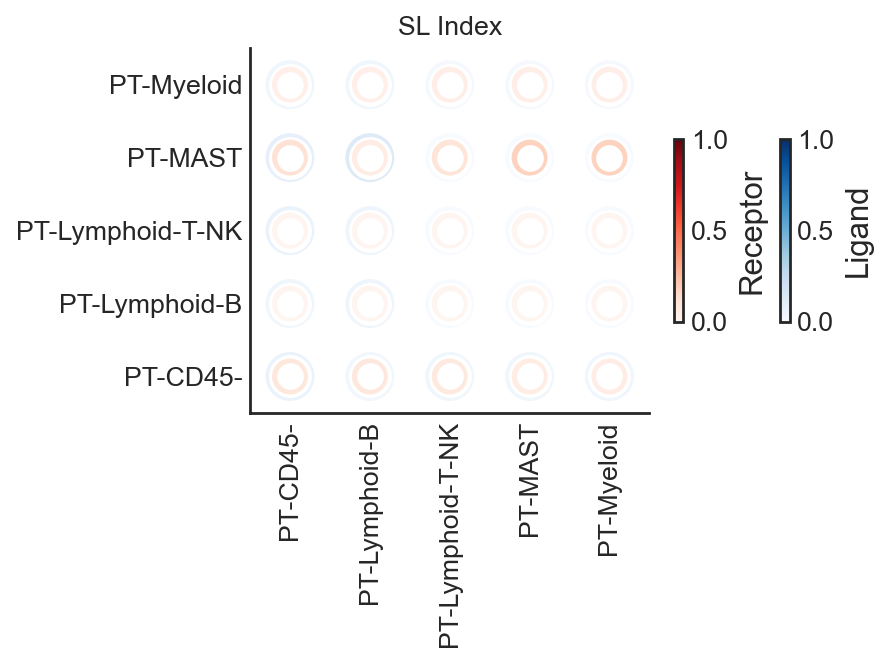

In [49]:
#c=kegg_result_ad['num'],cmap='Greens'

fig, ax = plt.subplots(figsize=(5,3))


plt.scatter(range(5),[0]*5,s=400,c=plot_data1['PT-CD45-'],cmap='Blues',linewidth=2,vmax=1,vmin=0)
plt.scatter(range(5),[1]*5,s=400,c=plot_data1['PT-Lymphoid-B'],cmap='Blues',linewidth=2,vmax=1,vmin=0)
plt.scatter(range(5),[2]*5,s=400,c=plot_data1['PT-Lymphoid-T-NK'],cmap='Blues',linewidth=2,vmax=1,vmin=0)
plt.scatter(range(5),[3]*5,s=400,c=plot_data1['PT-MAST'],cmap='Blues',linewidth=2,vmax=1,vmin=0)
plt.scatter(range(5),[4]*5,s=400,c=plot_data1['PT-Myeloid'],cmap='Blues',linewidth=2,vmax=1,vmin=0)


#position=pp.add_axes([1, 0.05, 0.7, 0.03])#位置[左,下,右,上]
cb=plt.colorbar(label="Ligand",shrink=0.5) 
cb.ax.tick_params(labelsize=12)

plt.scatter(range(5),[0]*5,s=300,color='w', edgecolors='w',linewidth=2)
plt.scatter(range(5),[1]*5,s=300,color='w', edgecolors='w',linewidth=2)
plt.scatter(range(5),[2]*5,s=300,color='w', edgecolors='w',linewidth=2)
plt.scatter(range(5),[3]*5,s=300,color='w', edgecolors='w',linewidth=2)
plt.scatter(range(5),[4]*5,s=300,color='w', edgecolors='w',linewidth=2)

plt.scatter(range(5),[0]*5,s=200,c=plot_data2['PT-CD45-'],cmap='Reds',linewidth=2,vmax=1,vmin=0)
plt.scatter(range(5),[1]*5,s=200,c=plot_data2['PT-Lymphoid-B'],cmap='Reds',linewidth=2,vmax=1,vmin=0)
plt.scatter(range(5),[2]*5,s=200,c=plot_data2['PT-Lymphoid-T-NK'],cmap='Reds',linewidth=2,vmax=1,vmin=0)
plt.scatter(range(5),[3]*5,s=200,c=plot_data2['PT-MAST'],cmap='Reds',linewidth=2,vmax=1,vmin=0)
plt.scatter(range(5),[4]*5,s=200,c=plot_data2['PT-Myeloid'],cmap='Reds',linewidth=2,vmax=1,vmin=0)

cb=plt.colorbar(label="Receptor",shrink=0.5) 
cb.ax.tick_params(labelsize=12)

plt.scatter(range(5),[0]*5,s=100,color='w', edgecolors='w',linewidth=2)
plt.scatter(range(5),[1]*5,s=100,color='w', edgecolors='w',linewidth=2)
plt.scatter(range(5),[2]*5,s=100,color='w', edgecolors='w',linewidth=2)
plt.scatter(range(5),[3]*5,s=100,color='w', edgecolors='w',linewidth=2)
plt.scatter(range(5),[4]*5,s=100,color='w', edgecolors='w',linewidth=2)

plt.xticks(range(5),de.columns[11:].tolist(),rotation=90,fontsize=12)
plt.yticks(range(5),de.columns[11:].tolist(),fontsize=12)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.xlim(-0.5,4.5)
plt.ylim(-0.5,4.5)
plt.title('SL Index',fontsize=12)
plt.savefig("result/fig2-pt-sl.png",dpi=300,bbox_inches = 'tight')

In [50]:
pvalue=pd.read_csv('content/out/pvalues.txt',sep='\t')
pvalue.set_index(pvalue.columns[1],inplace=True)
p=pvalue.loc[:,~pvalue.columns.str.contains('MT')]
p.head()

id_cp_interaction       partner_a      partner_b    gene_a  \
interacting_pair                                                              
KLRG2_WNT11        CPI-SS0A7B487D4   simple:A4D1S0  simple:O96014     KLRG2   
KLRG2_TNFSF9       CPI-SS0FEC87269   simple:A4D1S0  simple:P41273     KLRG2   
HLA-DPA1_TNFSF9    CPI-SS028784FC6  simple:HLADPA1  simple:P41273  HLA-DPA1   
PVR_TNFSF9         CPI-SS00A8596B5   simple:P15151  simple:P41273       PVR   
KLRG2_WNT5B        CPI-SS044DF8749   simple:A4D1S0  simple:Q9H1J7     KLRG2   

                  gene_b  secreted  receptor_a  receptor_b  \
interacting_pair                                             
KLRG2_WNT11        WNT11      True        True       False   
KLRG2_TNFSF9      TNFSF9      True        True       False   
HLA-DPA1_TNFSF9   TNFSF9      True        True       False   
PVR_TNFSF9        TNFSF9      True        True       False   
KLRG2_WNT5B        WNT5B      True        True       False   

                 annotation_strategy  is_integrin  ...  PT-MAST|PT-CD45-  \
interacting_pair                                   ...                     
KLRG2_WNT11             InnateDB-All        False  ...               1.0   
KLRG2_TNFSF9            InnateDB-All        False  ...               1.0   
HLA-DPA1_TNFSF9         InnateDB-All        False  ...               1.0   
PVR_TNFSF9              InnateDB-All        False  ...               1.0   
KLRG2_WNT5B             InnateDB-All        False  ...               1.0   

                  PT-MAST|PT-Lymphoid-B  PT-MAST|PT-Lymphoid-T-NK  \
interacting_pair                                                    
KLRG2_WNT11                        1.00                     1.000   
KLRG2_TNFSF9                       1.00                     1.000   
HLA-DPA1_TNFSF9                    0.96                     0.976   
PVR_TNFSF9                         1.00                     1.000   
KLRG2_WNT5B                        1.00                     1.000   

                  PT-MAST|PT-MAST  PT-MAST|PT-Myeloid  PT-Myeloid|PT-CD45-  \
interacting_pair                                                             
KLRG2_WNT11                 1.000               1.000                  1.0   
KLRG2_TNFSF9                1.000               1.000                  1.0   
HLA-DPA1_TNFSF9             0.984               0.912                  0.0   
PVR_TNFSF9                  1.000               1.000                  1.0   
KLRG2_WNT5B                 1.000               1.000                  1.0   

                  PT-Myeloid|PT-Lymphoid-B  PT-Myeloid|PT-Lymphoid-T-NK  \
interacting_pair                                                          
KLRG2_WNT11                            1.0                          1.0   
KLRG2_TNFSF9                           1.0                          1.0   
HLA-DPA1_TNFSF9                        0.0                          0.0   
PVR_TNFSF9                             1.0                          1.0   
KLRG2_WNT5B                            1.0                          1.0   

                  PT-Myeloid|PT-MAST  PT-Myeloid|PT-Myeloid  
interacting_pair                                             
KLRG2_WNT11                      1.0                    1.0  
KLRG2_TNFSF9                     1.0                    1.0  
HLA-DPA1_TNFSF9                  0.0                    0.0  
PVR_TNFSF9                       1.0                    1.0  
KLRG2_WNT5B                      1.0                    1.0  

[5 rows x 35 columns]

In [51]:
exp=sig_means1.loc[:,~sig_means1.columns.str.contains('MT')]
exp.head()

id_cp_interaction                  partner_a  \
interacting_pair                                                        
PlexinA2_complex1_SEMA3A   CPI-CS0D238C22B  complex:PlexinA2_complex1   
COL4A5_a11b1 complex       CPI-SC0CE433AB8              simple:P29400   
COL8A1_a11b1 complex       CPI-SC08CC68F11              simple:P27658   
COL5A3_a11b1 complex       CPI-SC07E958BDE              simple:P25940   
FGFR1_NCAM1                CPI-SS039799099              simple:P11362   

                                      partner_b  gene_a  gene_b  secreted  \
interacting_pair                                                            
PlexinA2_complex1_SEMA3A          simple:Q14563     NaN  SEMA3A      True   
COL4A5_a11b1 complex      complex:a11b1 complex  COL4A5     NaN      True   
COL8A1_a11b1 complex      complex:a11b1 complex  COL8A1     NaN      True   
COL5A3_a11b1 complex      complex:a11b1 complex  COL5A3     NaN      True   
FGFR1_NCAM1                       simple:P13591   FGFR1   NCAM1      True   

                          receptor_a  receptor_b annotation_strategy  \
interacting_pair                                                       
PlexinA2_complex1_SEMA3A        True       False             curated   
COL4A5_a11b1 complex           False       False             curated   
COL8A1_a11b1 complex           False       False             curated   
COL5A3_a11b1 complex           False       False             curated   
FGFR1_NCAM1                     True        True             curated   

                          is_integrin  ...  PT-MAST|PT-CD45-  \
interacting_pair                       ...                     
PlexinA2_complex1_SEMA3A        False  ...               NaN   
COL4A5_a11b1 complex             True  ...               NaN   
COL8A1_a11b1 complex             True  ...               NaN   
COL5A3_a11b1 complex             True  ...               NaN   
FGFR1_NCAM1                     False  ...               NaN   

                          PT-MAST|PT-Lymphoid-B  PT-MAST|PT-Lymphoid-T-NK  \
interacting_pair                                                            
PlexinA2_complex1_SEMA3A                    NaN                       NaN   
COL4A5_a11b1 complex                        NaN                       NaN   
COL8A1_a11b1 complex                        NaN                       NaN   
COL5A3_a11b1 complex                        NaN                       NaN   
FGFR1_NCAM1                                 NaN                       NaN   

                          PT-MAST|PT-MAST  PT-MAST|PT-Myeloid  \
interacting_pair                                                
PlexinA2_complex1_SEMA3A              NaN                 NaN   
COL4A5_a11b1 complex                  NaN                 NaN   
COL8A1_a11b1 complex                  NaN                 NaN   
COL5A3_a11b1 complex                  NaN                 NaN   
FGFR1_NCAM1                           NaN                 NaN   

                          PT-Myeloid|PT-CD45-  PT-Myeloid|PT-Lymphoid-B  \
interacting_pair                                                          
PlexinA2_complex1_SEMA3A                  NaN                       NaN   
COL4A5_a11b1 complex                      NaN                       NaN   
COL8A1_a11b1 complex                      NaN                       NaN   
COL5A3_a11b1 complex                      NaN                       NaN   
FGFR1_NCAM1                               NaN                       NaN   

                          PT-Myeloid|PT-Lymphoid-T-NK  PT-Myeloid|PT-MAST  \
interacting_pair                                                            
PlexinA2_complex1_SEMA3A                          NaN                 NaN   
COL4A5_a11b1 complex                              NaN                 NaN   
COL8A1_a11b1 complex                              NaN                 NaN   
COL5A3_a11b1 complex                              NaN                 NaN   
FGFR1_NCAM1                        

In [52]:
def find_pt_mt():
    test=exp.loc[:,exp.columns.str.contains('\|PT-')]
    test1=test.loc[:,~test.columns.str.contains('MT-')]
    return test1.columns.tolist()

In [53]:
plot_data3=pd.DataFrame(columns=['Pair','means','p-value','Type'])
p_pair=find_pt_mt()
#res2=[i.replace('-','_') for i in res1]
for i in list(set(res1)):
    #i=i.replace('-','_')
    plot_data4=pd.DataFrame()
    plot_data4['Pair']=[j for j in [i]*len(p_pair)]
    plot_data4['means']=exp.loc[i,p_pair].values
    plot_data4['p-value']=-np.log10(p.loc[i,p_pair].values.tolist())+0.3
    plot_data4['Type']=p_pair
    
    plot_data3=pd.concat([plot_data3,plot_data4])
plot_data3=plot_data3.fillna(0)

plot_data3['means']=np.log2(plot_data3['means'])
plot_data3=plot_data3.replace(float('inf'),3)
plot_data3=plot_data3.replace(float('-inf'),-3)
plot_data3.head()

/var/folders/4m/2xw3_2s503s9r616083n7w440000gn/T/ipykernel_787/2838547948.py:9: RuntimeWarning: divide by zero encountered in log10
  plot_data4['p-value']=-np.log10(p.loc[i,p_pair].values.tolist())+0.3
/var/folders/4m/2xw3_2s503s9r616083n7w440000gn/T/ipykernel_787/2838547948.py:9: RuntimeWarning: divide by zero encountered in log10
  plot_data4['p-value']=-np.log10(p.loc[i,p_pair].values.tolist())+0.3
/var/folders/4m/2xw3_2s503s9r616083n7w440000gn/T/ipykernel_787/2838547948.py:9: RuntimeWarning: divide by zero encountered in log10
  plot_data4['p-value']=-np.log10(p.loc[i,p_pair].values.tolist())+0.3
/var/folders/4m/2xw3_2s503s9r616083n7w440000gn/T/ipykernel_787/2838547948.py:9: RuntimeWarning: divide by zero encountered in log10
  plot_data4['p-value']=-np.log10(p.loc[i,p_pair].values.tolist())+0.3
/var/folders/4m/2xw3_2s503s9r616083n7w440000gn/T/ipykernel_787/2838547948.py:9: RuntimeWarning: divide by zero encountered in log10
  plot_data4['p-value']=-np.log10(p.loc[i,p_pair].values

Pair     means   p-value                       Type
0  PLXNB2_SEMA4D -3.000000  0.481774          PT-CD45-|PT-CD45-
1  PLXNB2_SEMA4D -1.000000  3.000000     PT-CD45-|PT-Lymphoid-B
2  PLXNB2_SEMA4D -0.601650  3.000000  PT-CD45-|PT-Lymphoid-T-NK
3  PLXNB2_SEMA4D -0.316528  3.000000           PT-CD45-|PT-MAST
4  PLXNB2_SEMA4D -1.077041  2.697940        PT-CD45-|PT-Myeloid

[Text(0, 1, 'EGFR_TGFB1'),
 Text(0, 2, 'CD55_ADGRE5'),
 Text(0, 3, 'HGF_CD44'),
 Text(0, 4, 'TNFSF10_RIPK1'),
 Text(0, 5, 'LAMP1_FAM3C'),
 Text(0, 6, 'TNFRSF10B_TNFSF10'),
 Text(0, 7, 'SIRPA_CD47'),
 Text(0, 8, 'ADORA2A_NAMPT'),
 Text(0, 9, 'NTRK1_NAMPT'),
 Text(0, 10, 'EGFR_COPA'),
 Text(0, 11, 'IGF2_IDE'),
 Text(0, 12, 'SPP1_CD44'),
 Text(0, 13, 'CD2_CD58'),
 Text(0, 14, 'C5AR1_RPS19'),
 Text(0, 15, 'EGFR_MIF'),
 Text(0, 16, 'NTRK1_GPI'),
 Text(0, 17, 'MIF_TNFRSF14'),
 Text(0, 18, 'CD72_SEMA4D'),
 Text(0, 19, 'CD74_COPA'),
 Text(0, 20, 'NTRK1_COPA'),
 Text(0, 21, 'HLA-C_FAM3C'),
 Text(0, 22, 'PDCD1_FAM3C'),
 Text(0, 23, 'JAG1_NOTCH2'),
 Text(0, 24, 'DLL1_NOTCH2'),
 Text(0, 25, 'TNF_RIPK1'),
 Text(0, 26, 'CD74_MIF'),
 Text(0, 27, 'PLXNB2_SEMA4D')]

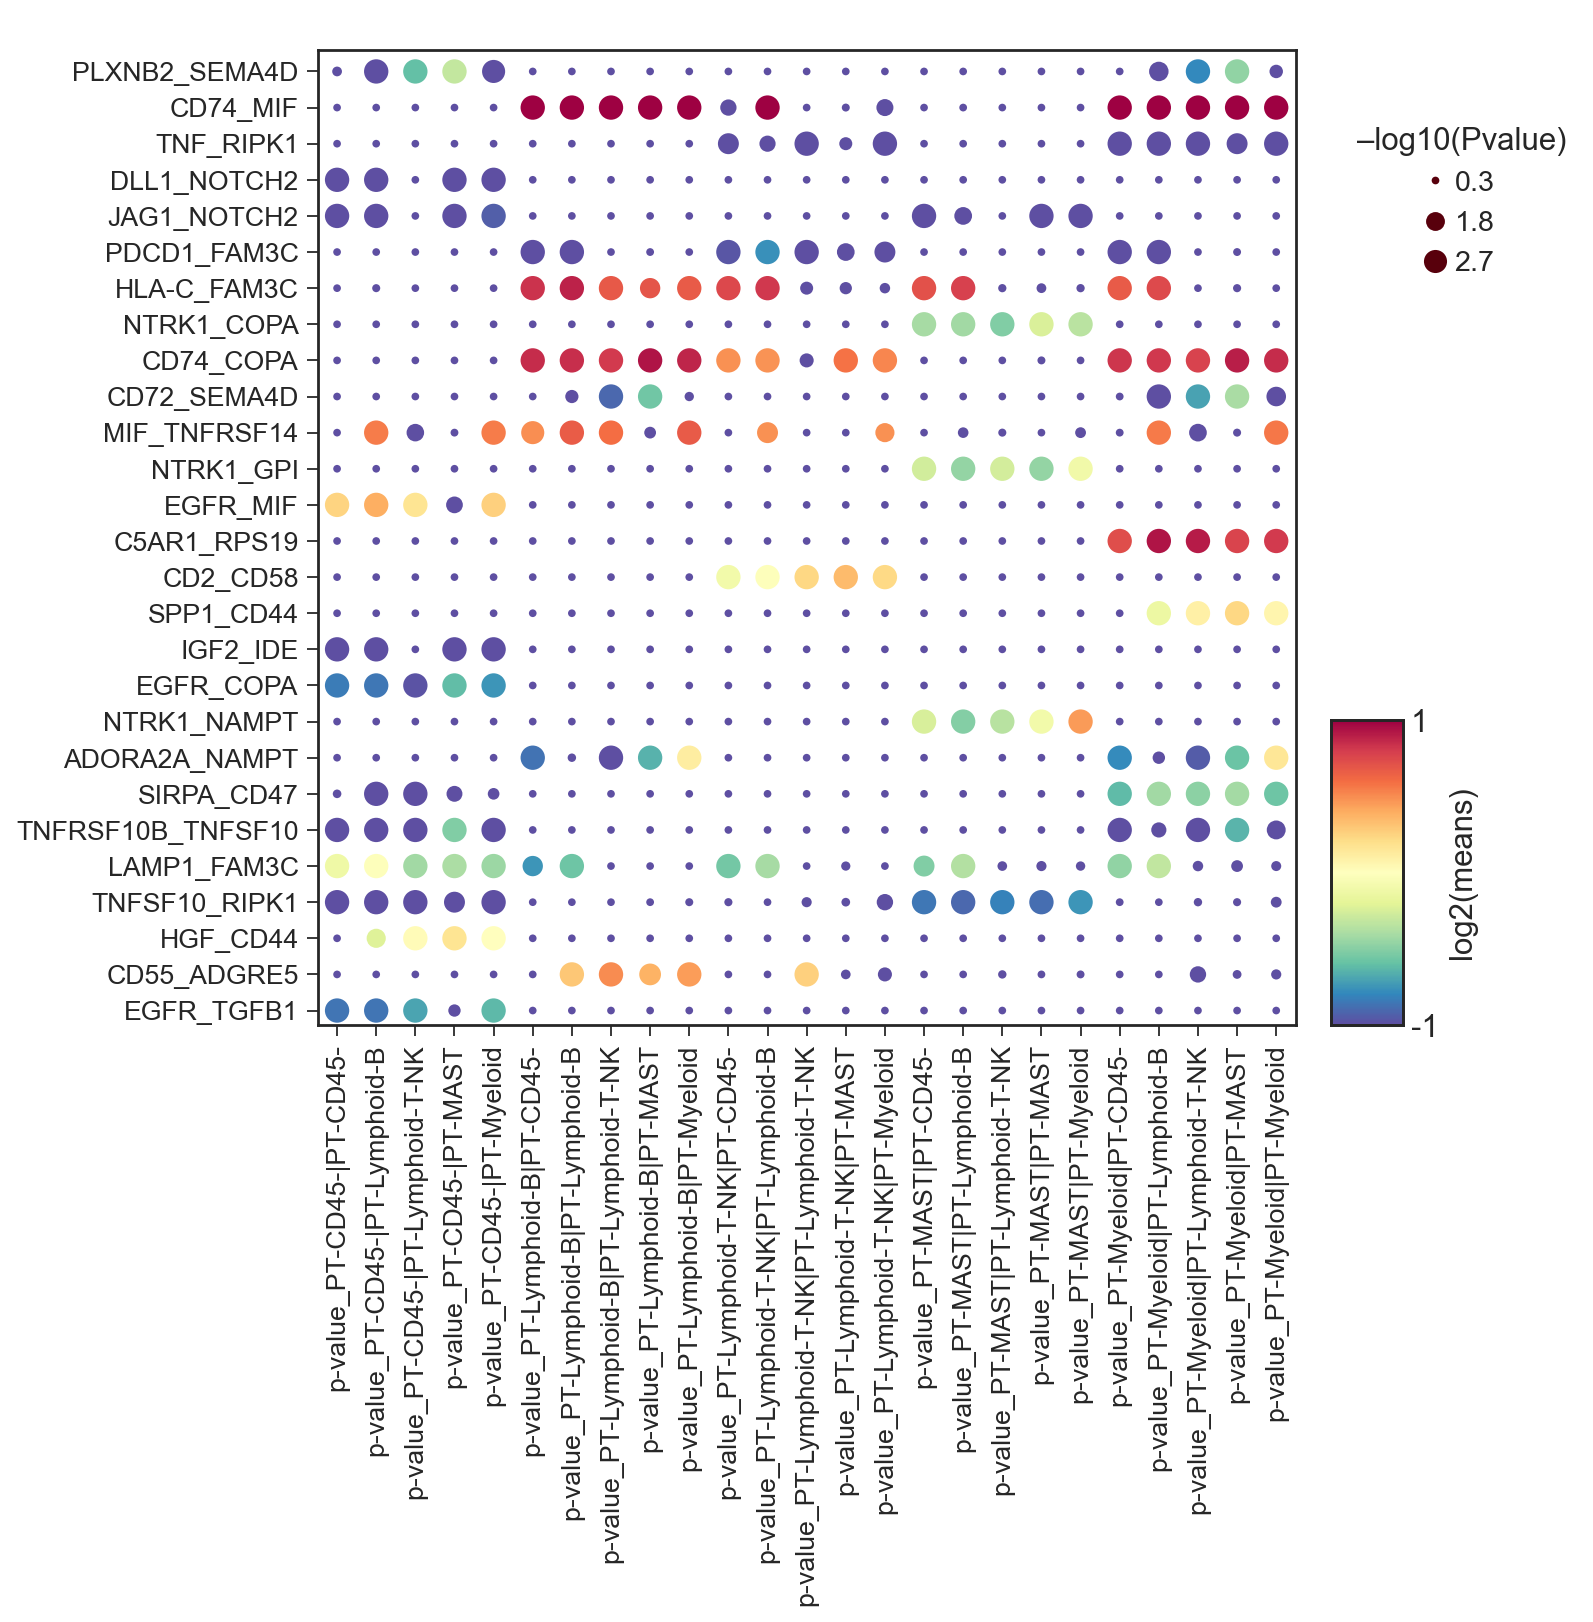

In [54]:
import dotplot
new_keys = {'item_key': 'Pair','group_key': 'Type','sizes_key': 'p-value','color_key': 'means'}
dp = dotplot.DotPlot.parse_from_tidy_data(plot_data3, **new_keys)
ax = dp.plot(size_factor=40, cmap='Spectral_r',
             dot_title = '–log10(Pvalue)', colorbar_title = 'log2(means)',vmin=-1,vmax=1)

xlabs=ax.get_axes()[0].get_xticklabels()
ax.get_axes()[0].set_xticklabels(xlabs,fontsize=12)
ylabs=ax.get_axes()[0].get_yticklabels()
ax.get_axes()[0].set_yticklabels(ylabs,fontsize=12)

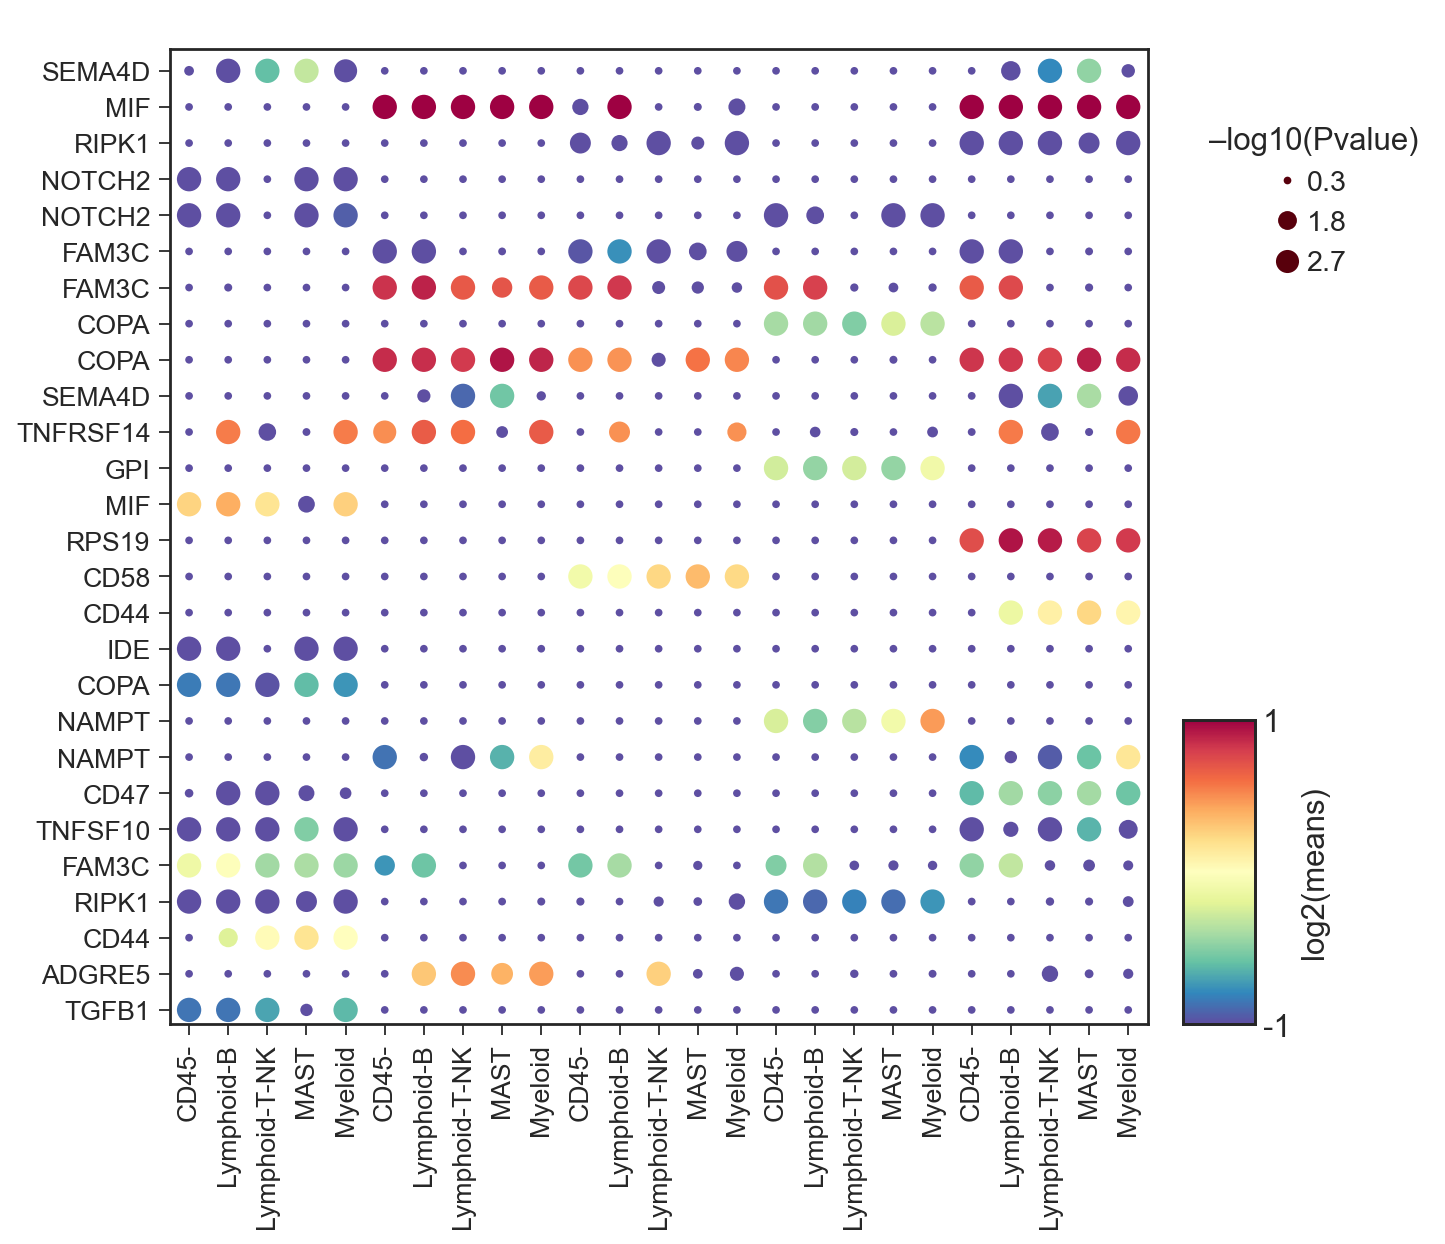

In [55]:
[i.set_text(i.get_text().split('|')[1].replace('PT-','')) for i in xlabs]
ax.get_axes()[0].set_xticklabels(xlabs,fontsize=12)

[i.set_text(i.get_text().split('_')[1]) for i in ylabs]
ax.get_axes()[0].set_yticklabels(ylabs,fontsize=12)
ax

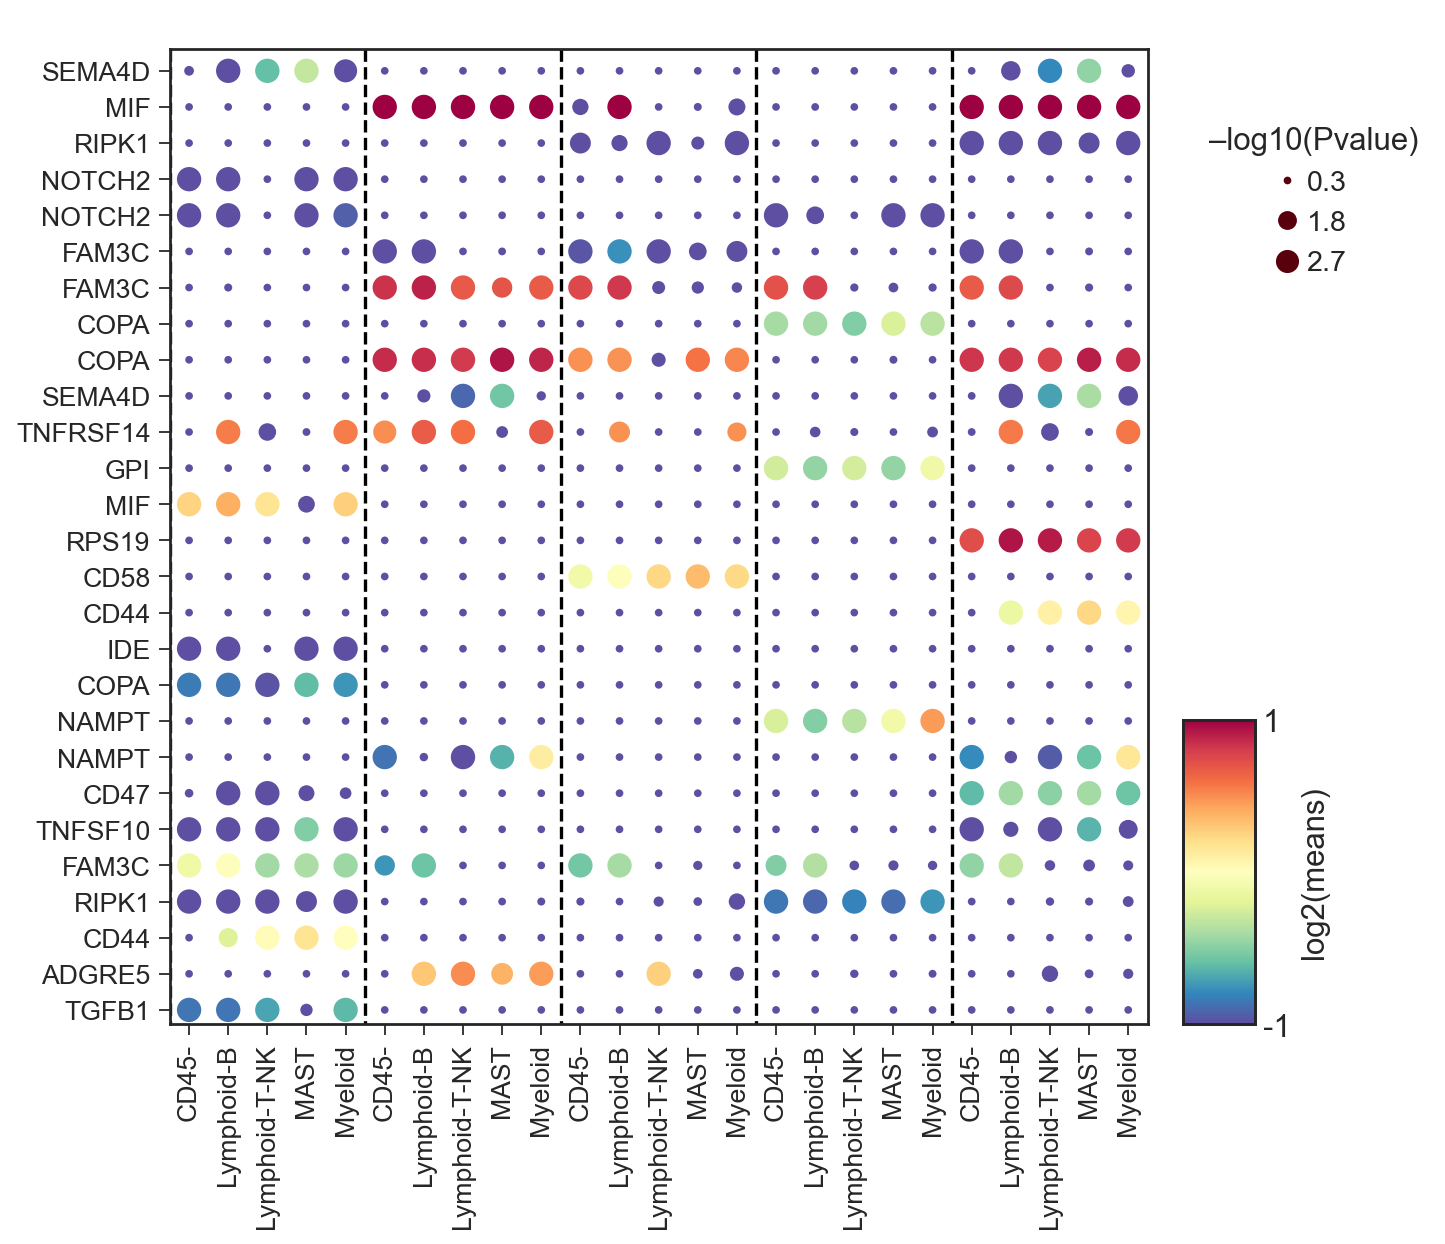

In [56]:
for i in range(len(xlabs)):
    if i%5==0:
        ax.get_axes()[0].axvline(x=i+0.5, ymin=-1, ymax=10,color='black',linestyle="--")
ax

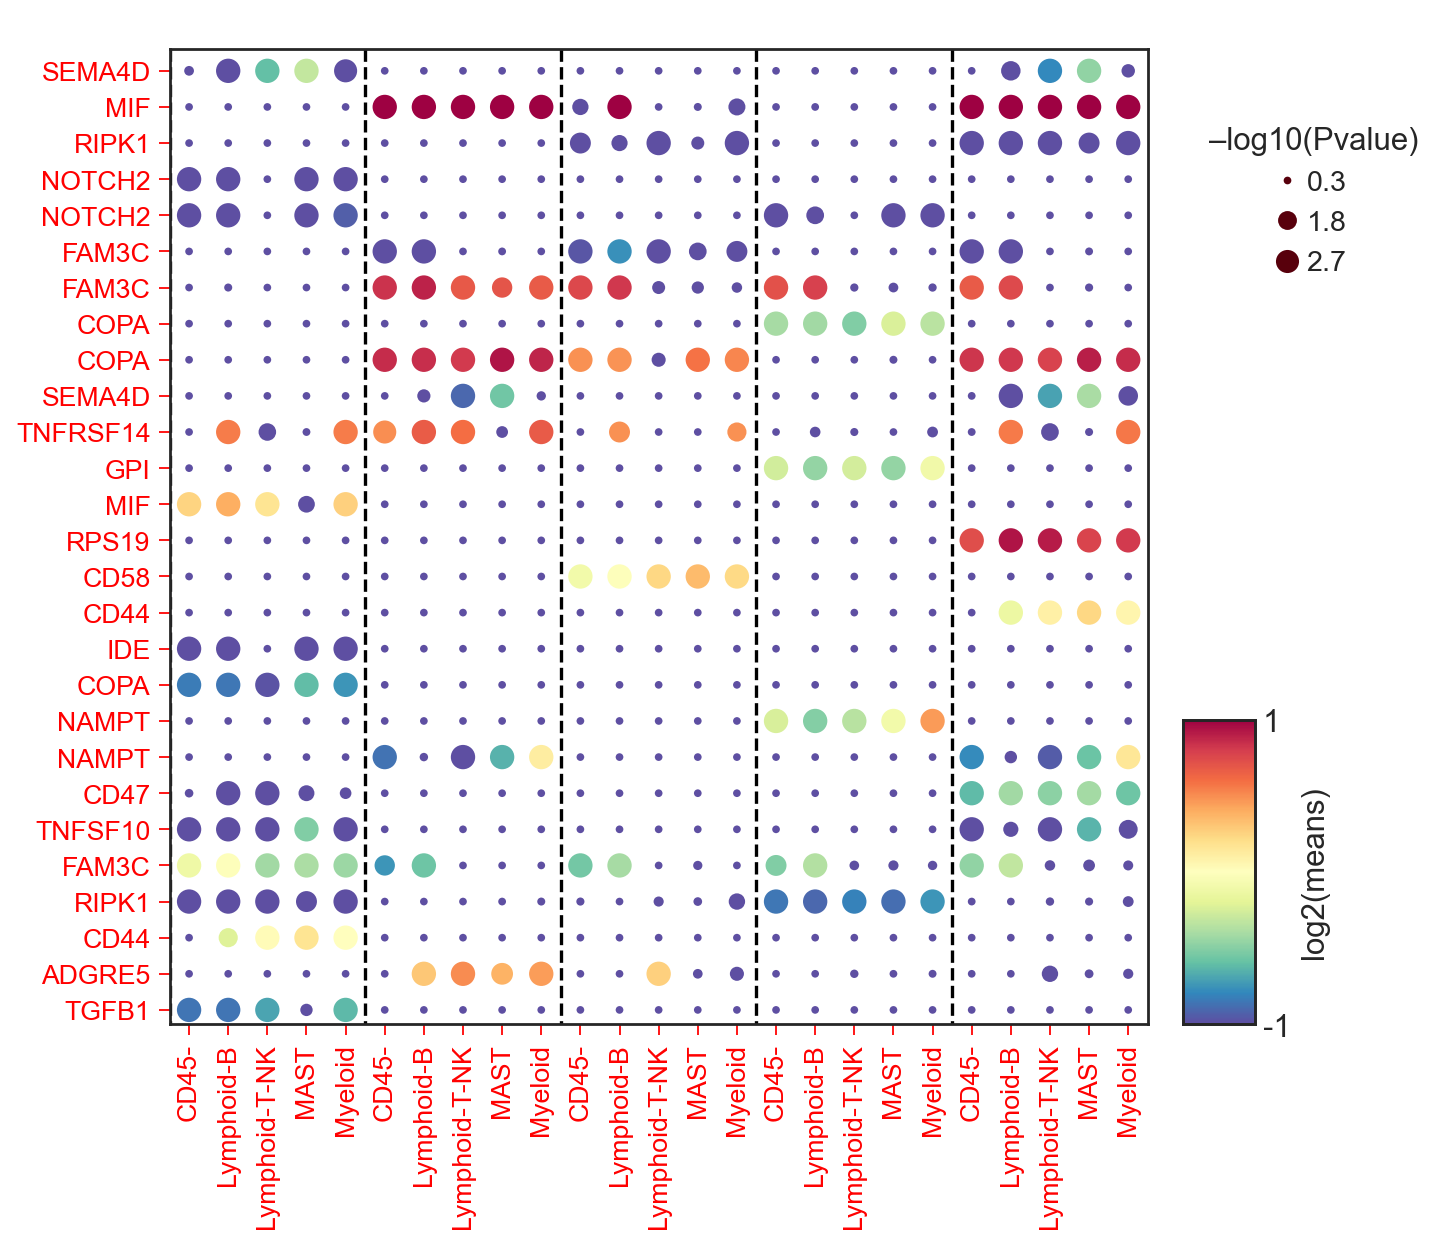

In [57]:
ax.get_axes()[0].tick_params(axis='both',colors='red', which='both')
ax.savefig("result/figure3B_PT_receptor.png",dpi=300,bbox_inches = 'tight')
ax

[Text(0, 1, 'EGFR_TGFB1'),
 Text(0, 2, 'CD55_ADGRE5'),
 Text(0, 3, 'HGF_CD44'),
 Text(0, 4, 'TNFSF10_RIPK1'),
 Text(0, 5, 'LAMP1_FAM3C'),
 Text(0, 6, 'TNFRSF10B_TNFSF10'),
 Text(0, 7, 'SIRPA_CD47'),
 Text(0, 8, 'ADORA2A_NAMPT'),
 Text(0, 9, 'NTRK1_NAMPT'),
 Text(0, 10, 'EGFR_COPA'),
 Text(0, 11, 'IGF2_IDE'),
 Text(0, 12, 'SPP1_CD44'),
 Text(0, 13, 'CD2_CD58'),
 Text(0, 14, 'C5AR1_RPS19'),
 Text(0, 15, 'EGFR_MIF'),
 Text(0, 16, 'NTRK1_GPI'),
 Text(0, 17, 'MIF_TNFRSF14'),
 Text(0, 18, 'CD72_SEMA4D'),
 Text(0, 19, 'CD74_COPA'),
 Text(0, 20, 'NTRK1_COPA'),
 Text(0, 21, 'HLA-C_FAM3C'),
 Text(0, 22, 'PDCD1_FAM3C'),
 Text(0, 23, 'JAG1_NOTCH2'),
 Text(0, 24, 'DLL1_NOTCH2'),
 Text(0, 25, 'TNF_RIPK1'),
 Text(0, 26, 'CD74_MIF'),
 Text(0, 27, 'PLXNB2_SEMA4D')]

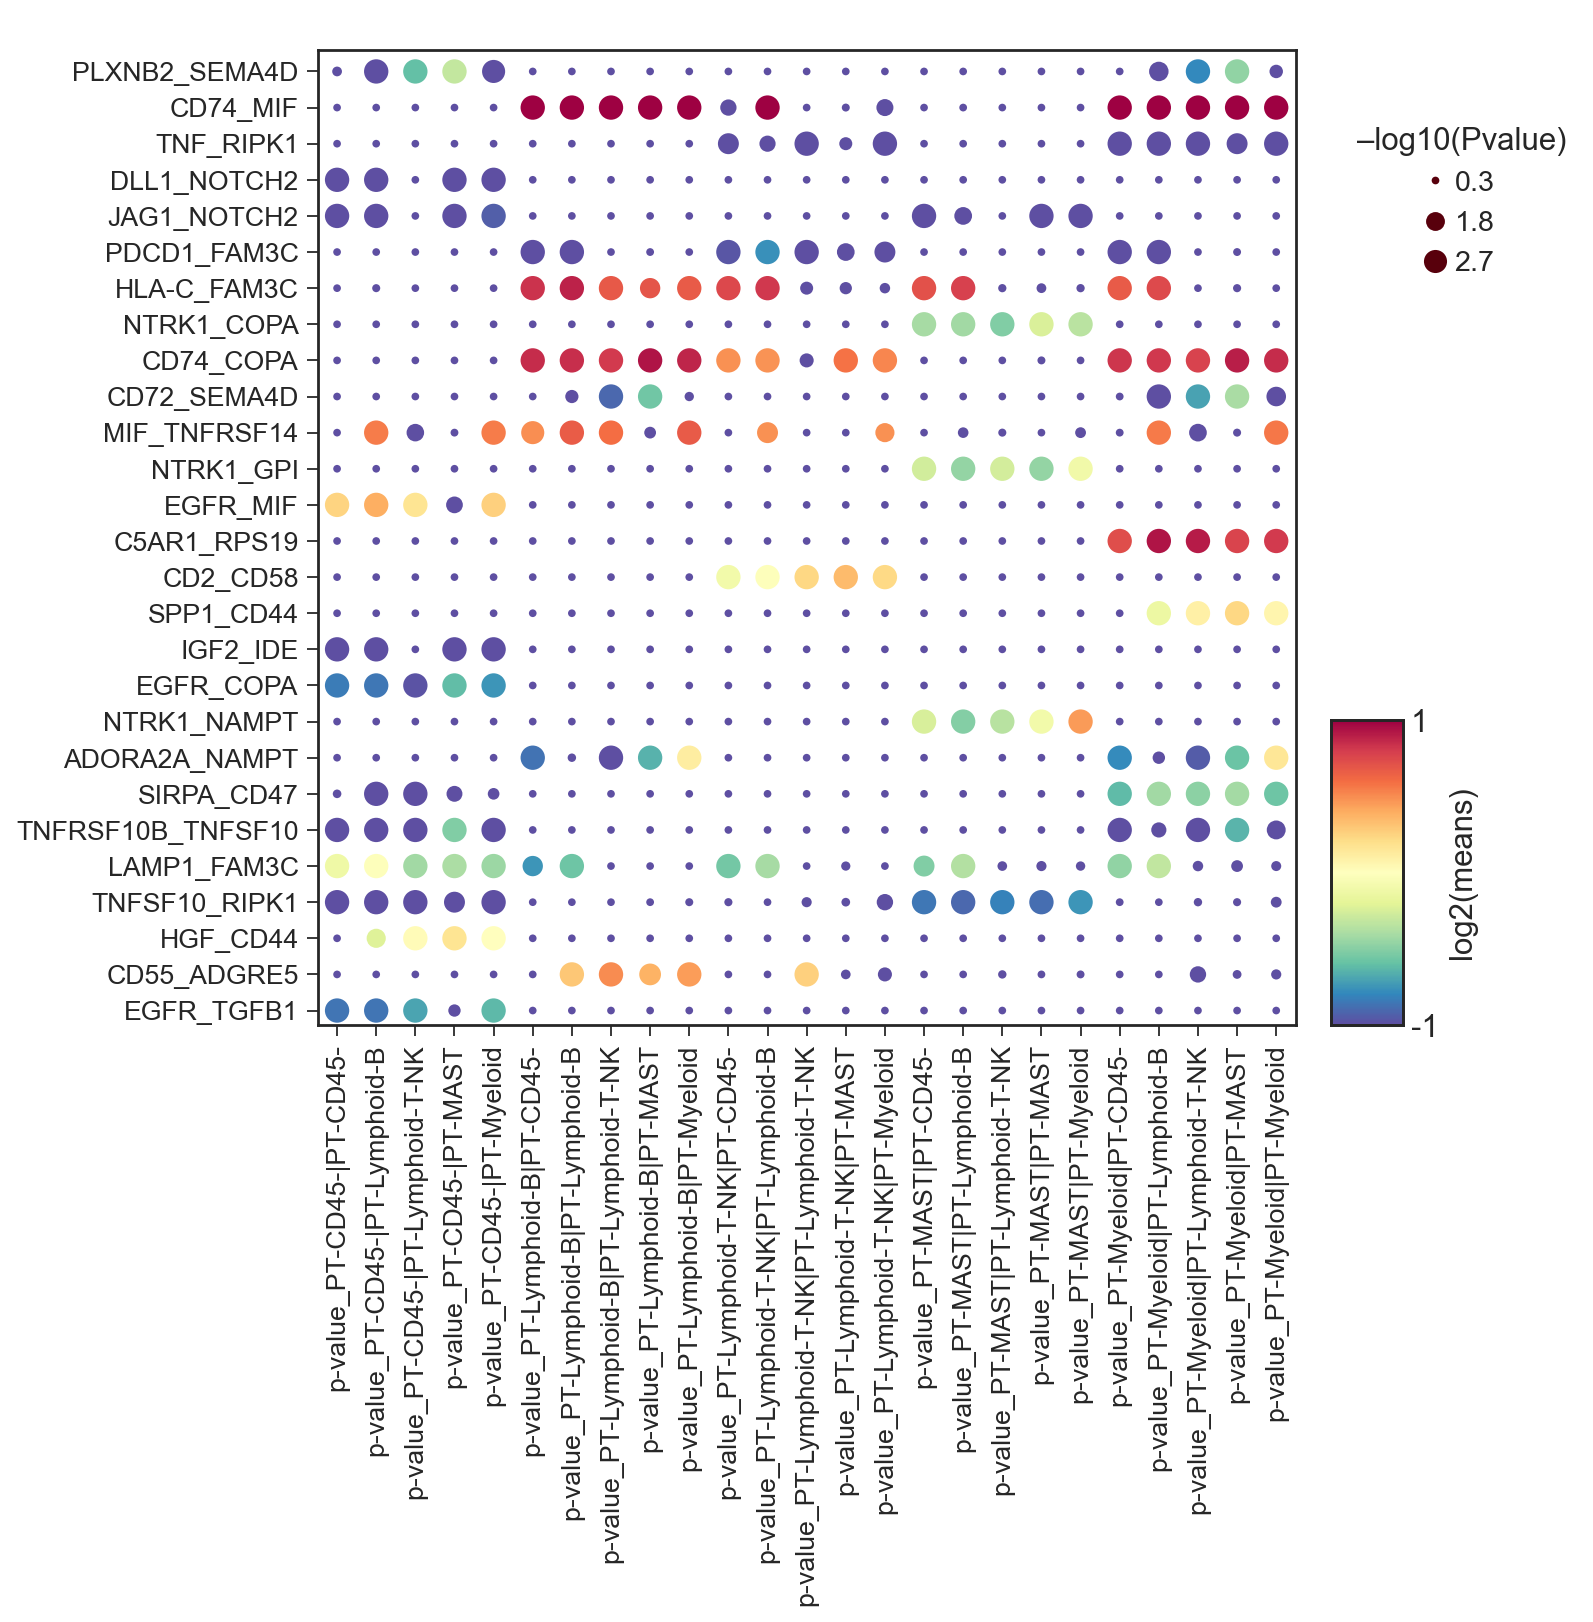

In [58]:

new_keys = {'item_key': 'Pair','group_key': 'Type','sizes_key': 'p-value','color_key': 'means'}
dp = dotplot.DotPlot.parse_from_tidy_data(plot_data3, **new_keys)
ax = dp.plot(size_factor=40, cmap='Spectral_r',
             dot_title = '–log10(Pvalue)', colorbar_title = 'log2(means)',vmin=-1,vmax=1)

xlabs=ax.get_axes()[0].get_xticklabels()
ax.get_axes()[0].set_xticklabels(xlabs,fontsize=12)
ylabs=ax.get_axes()[0].get_yticklabels()
ax.get_axes()[0].set_yticklabels(ylabs,fontsize=12)

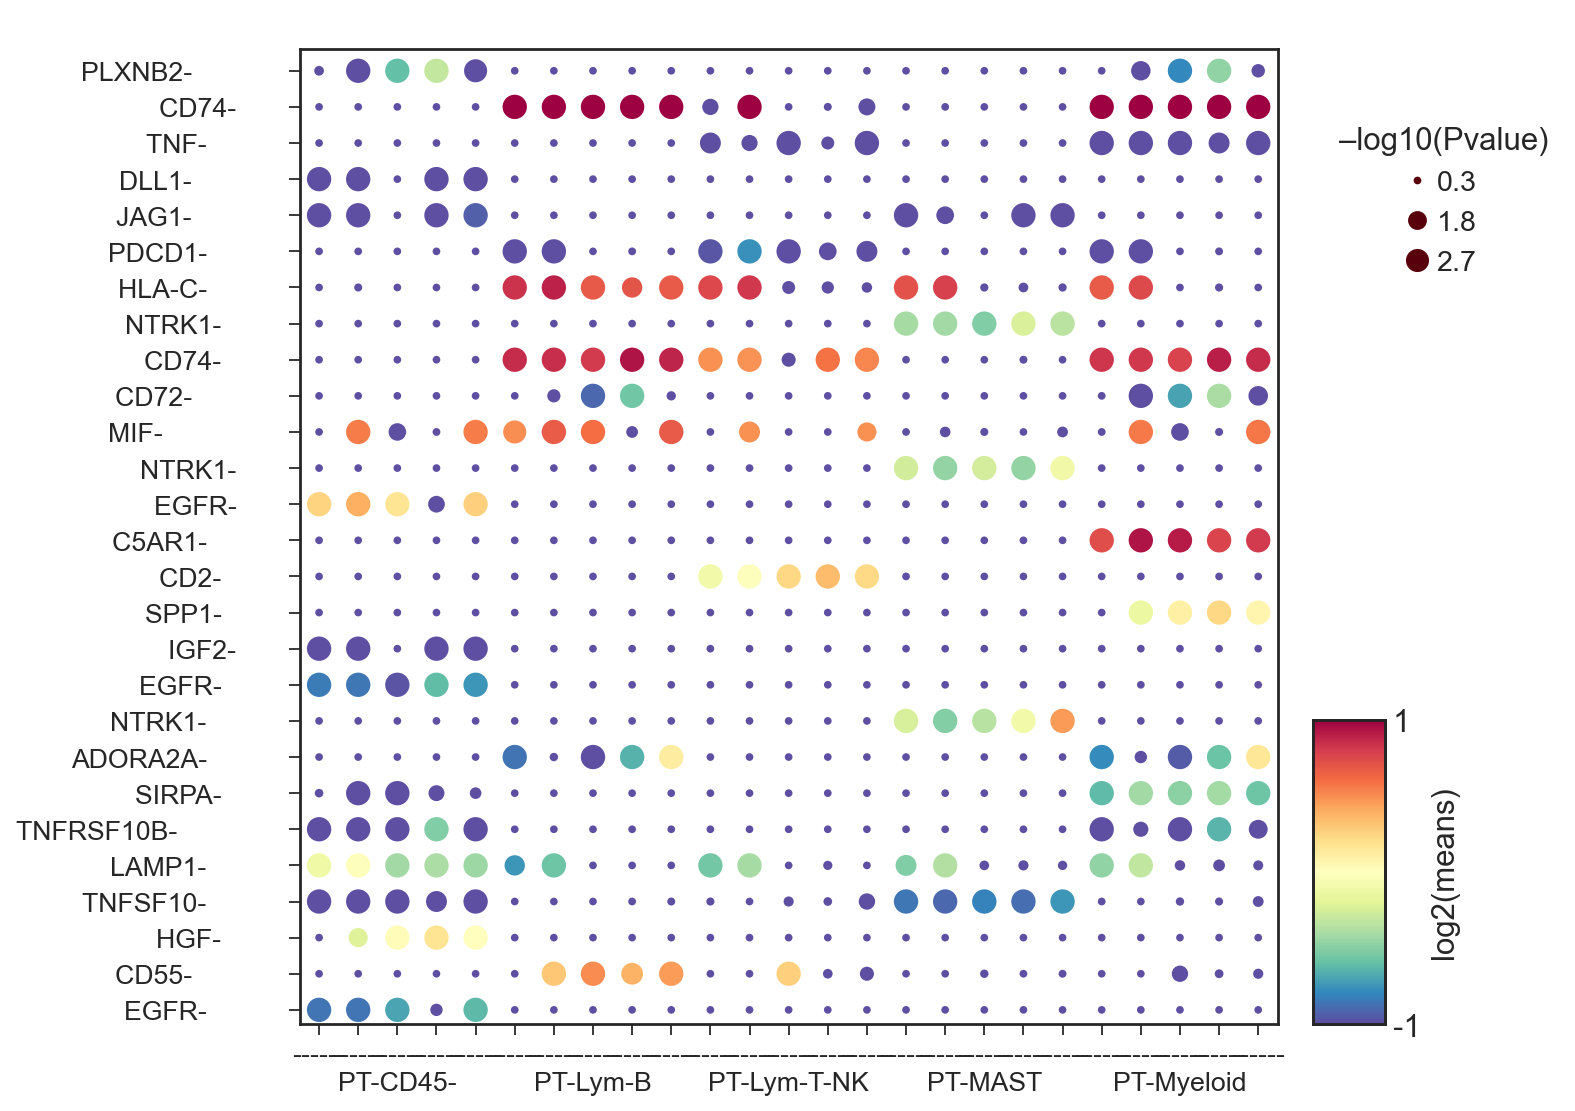

In [59]:
[xlabs[i].set_text('------') for i in range(len(xlabs)) if (i+3)%5!=0]
[xlabs[i].set_text('------\n'+xlabs[i].get_text().replace('p-value_','').replace('Lymphoid','Lym').split('|')[0]) for i in range(len(xlabs)) if (i+3)%5==0]
ax.get_axes()[0].set_xticklabels(xlabs,fontsize=12,rotation=0)

[i.set_text(i.get_text().split('_')[0]+'-'+'  '*len(i.get_text().split('_')[1])) for i in ylabs]
ax.get_axes()[0].set_yticklabels(ylabs,fontsize=12)
ax

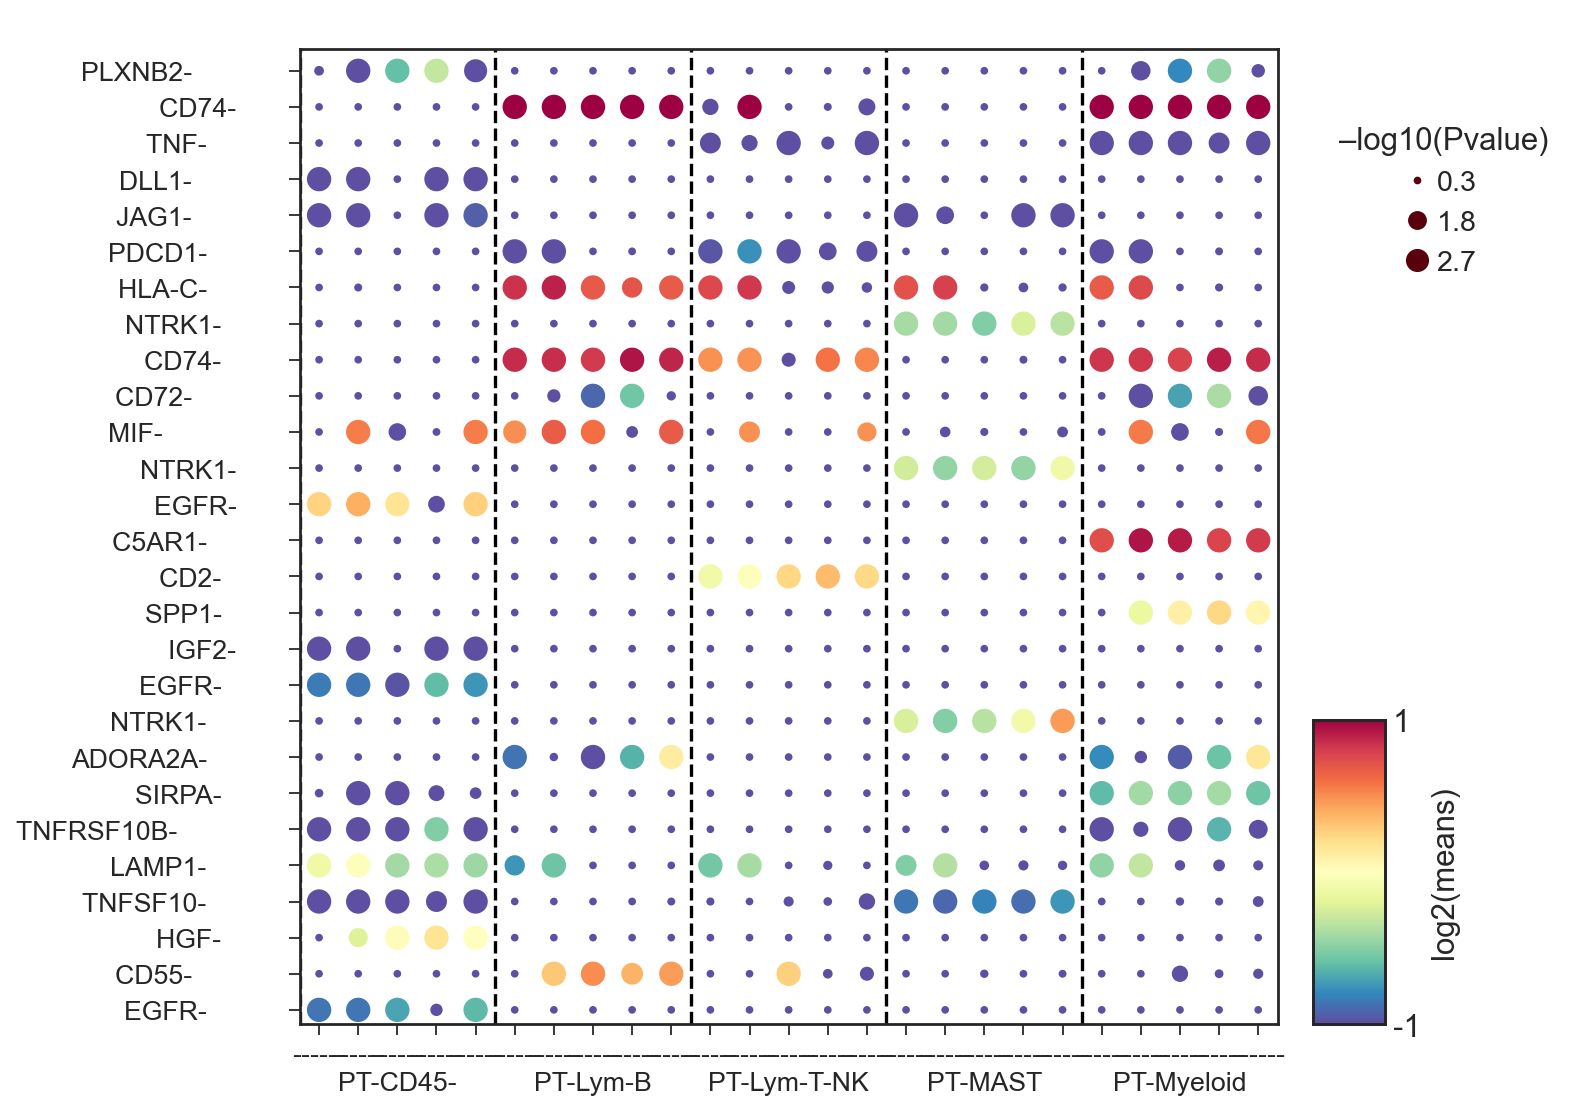

In [60]:
for i in range(len(xlabs)):
    if i%5==0:
        ax.get_axes()[0].axvline(x=i+0.5, ymin=-1, ymax=10,color='black',linestyle="--")
ax

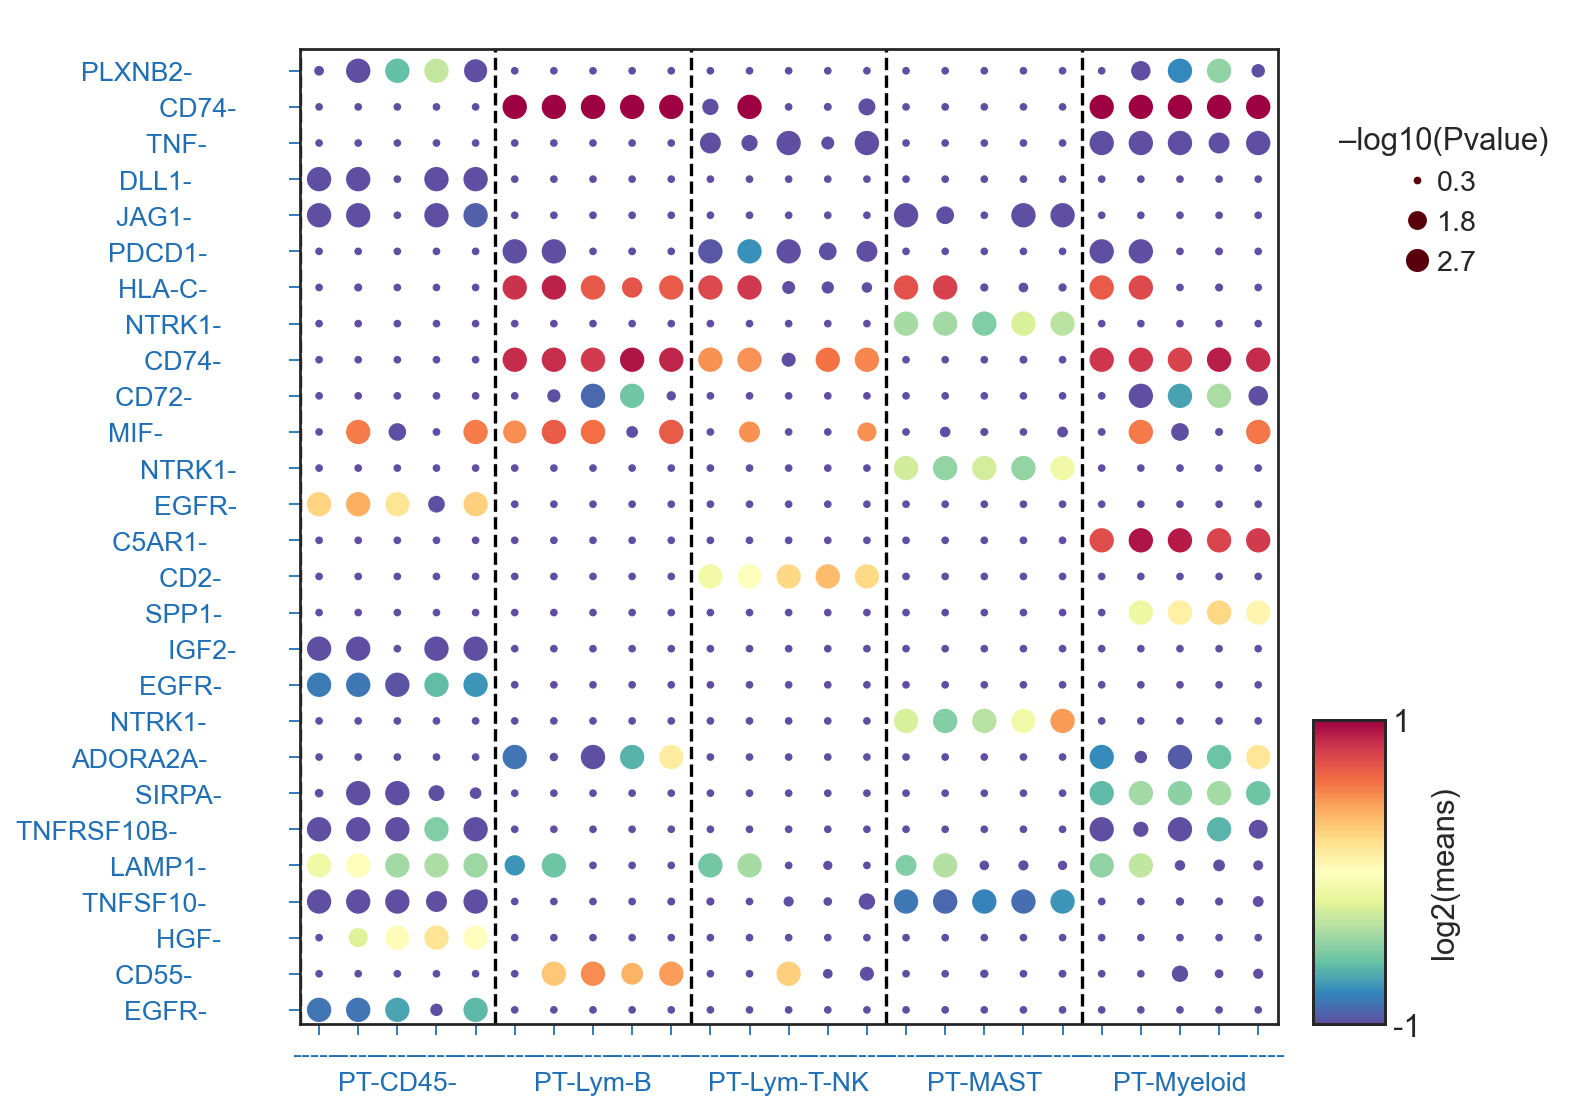

In [61]:
ax.get_axes()[0].tick_params(axis='both',colors='#206FB4', which='major')
ax.savefig("result/figure3B_PT-ligand.png",dpi=300,bbox_inches = 'tight')
ax

In [78]:
SL_pair=pd.read_csv('sl-for-scrnaseq-full.csv')
SL_pair['raw']=SL_pair['gene1']+'-'+SL_pair['gene2']
SL_pair['rev']=SL_pair['gene2']+'-'+SL_pair['gene1']
SL_pair.head()

gene1    gene2           raw           rev
0  ITGB1     BCL2    ITGB1-BCL2    BCL2-ITGB1
1  ANXA5   DUSP18  ANXA5-DUSP18  DUSP18-ANXA5
2   CYBA  ZFP36L1  CYBA-ZFP36L1  ZFP36L1-CYBA
3   CTSC  S100A11  CTSC-S100A11  S100A11-CTSC
4   CTSD    WIPI2    CTSD-WIPI2    WIPI2-CTSD

In [81]:
SL_pair.shape

(56525, 4)

In [91]:
'ITGB1-BCL2' in SL_pair['raw'].values

True

In [84]:
res_name=[]
for name in [i.replace('_','-') for i in res]:
    if name in SL_pair['rev'].values:
        res_name.append(name)
    elif name in SL_pair['raw'].values:
        res_name.append(name)
res_name

[]

In [253]:
for i in res1 :
    if i not in res:
        print(i)

EGFR-MIF
EGFR-COPA
JAG1-NOTCH2
EGFR-TGFB1
CXCL2-DPP4
LAMP1-FAM3C
TNFSF10-TNFRSF10D
MIF-TNFRSF10D
MIF-TNFRSF14
CD74-MIF
CD74-COPA
CD55-ADGRE5
CD74-APP
CD2-CD58
TNFRSF10A-TNFSF10
NTRK1-COPA
NTRK1-GPI
NTRK1-NAMPT
JAG1-NOTCH2
BMP7-SLAMF1
CD74-MIF
C5AR1-RPS19
CD74-COPA
SPP1-CD44
TNFRSF10B-TNFSF10
SIRPA-CD47
CXCL2-DPP4
AXL-GAS6
TNFSF12-TNFRSF25
CD74-APP
MIF-TNFRSF10D


In [95]:
for i in res1:
    a1,a2=i.split('-')
    if (a1 in sl_type_all['gene1'].values) and (a2 in sl_type_all['gene2'].values):
        print(a1,a2,sl_type_all.loc[sl_type_all['gene1']==a1,'All_Type'].mean(),
             sl_type_all.loc[sl_type_all['gene2']==a2,'All_Type'].mean())
    elif (a1 in sl_type_all['gene2'].values) and (a2 in sl_type_all['gene1'].values):
        print(a1,a2,sl_type_all.loc[sl_type_all['gene2']==a1,'All_Type'].mean(),
             sl_type_all.loc[sl_type_all['gene1']==a2,'All_Type'].mean())

JAG1 NOTCH2 0.0 0.25
CXCL2 DPP4 0.3333333333333333 1.0
LAMP1 FAM3C 0.25 0.0
TNFSF10 TNFRSF10D 0.0 0.0
MIF TNFRSF14 0.0 0.0
CD74 MIF 0.0 0.0
CD74 COPA 0.0 0.0
CD74 APP 0.0 0.0
TNFRSF10A TNFSF10 0.0 0.0
JAG1 NOTCH2 0.0 0.25
CD74 MIF 0.0 0.0
C5AR1 RPS19 0.1111111111111111 0.0
CD74 COPA 0.0 0.0
TNFRSF10B TNFSF10 0.0 0.0
SIRPA CD47 0.0 0.3333333333333333
CXCL2 DPP4 0.3333333333333333 1.0
AXL GAS6 0.0625 0.0
TNFSF12 TNFRSF25 0.0 1.0
CD74 APP 0.0 0.0


In [60]:
sl_type_all=pd.read_csv('SL_type_all.csv')
sl_type_all.set_index(sl_type_all.columns[0],inplace=True)
sl_type_all['gene1']=[i.split('-')[0] for i in sl_type_all.index]
sl_type_all['gene2']=[i.split('-')[1] for i in sl_type_all.index]
sl_type_all['rev']=[i.split('-')[1]+'-'+i.split('-')[0] for i in sl_type_all.index]
sl_type_all['raw']=[i.split('-')[0]+'-'+i.split('-')[1] for i in sl_type_all.index]
sl_type_all.head()

All_Type   gene1   gene2          rev          raw
Unnamed: 0                                                     
CYP1B1-MOK          1  CYP1B1     MOK   MOK-CYP1B1   CYP1B1-MOK
GDI2-HNRNPF         0    GDI2  HNRNPF  HNRNPF-GDI2  GDI2-HNRNPF
EXT2-RABIF          0    EXT2   RABIF   RABIF-EXT2   EXT2-RABIF
KRAS-MAPRE1         0    KRAS  MAPRE1  MAPRE1-KRAS  KRAS-MAPRE1
BLM-CBX6            0     BLM    CBX6     CBX6-BLM     BLM-CBX6

# Venn

In [62]:
list(set(MT_res1) & set(PT_res1))

['CD74_MIF',
 'C5AR1_RPS19',
 'NTRK1_COPA',
 'NTRK1_NAMPT',
 'CD74_COPA',
 'JAG1_NOTCH2',
 'SPP1_CD44',
 'CD55_ADGRE5',
 'NTRK1_GPI',
 'EGFR_MIF',
 'EGFR_COPA']

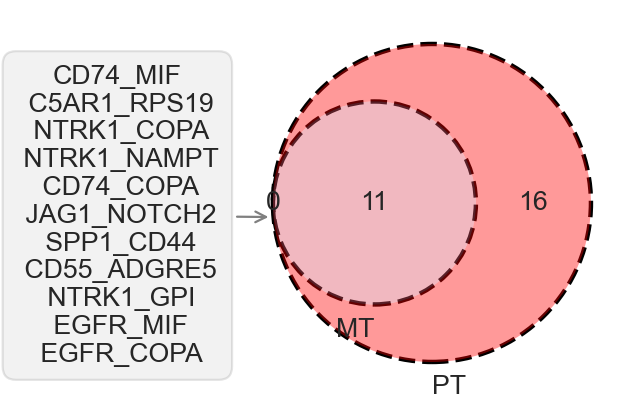

In [63]:
from matplotlib_venn import venn2,venn2_circles
fig, ax = plt.subplots(figsize=(3,5))
venn2_circles(subsets=[set(MT_res1),set(PT_res1)],
        linestyle='--', linewidth=2, color="black",#外框线型、线宽、颜色
        normalize_to=1.0,ax=ax,
       )
dv_colors=['#3C718D','red']
v=venn2(subsets=[set(MT_res1),set(PT_res1)],
      set_labels=('MT','PT'),
      set_colors=(dv_colors[0],dv_colors[1]),ax=ax,
       normalize_to=1.0,)

v.get_label_by_id('10').set_fontsize(12)#1的大小设置为20
v.get_label_by_id('01').set_fontsize(12)#1的大小设置为20
v.get_label_by_id('11').set_fontsize(12)#1的大小设置为20
for t in v.set_labels: 
    t.set_fontsize(12) 

gene_name=list(set(MT_res1) & set(PT_res1))   
    
plt.annotate(str(gene_name).replace(',','\n').replace("'",'').replace('[','').replace(']',''), xy=v.get_label_by_id('10').get_position() - np.array([0, 0.05]), xytext=(-70,-65),
             ha='center', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),
             arrowprops=dict(arrowstyle='->', color='gray'),size=12)
    
#from matplotlib.transforms import Affine2D
#ax = gca()
#t = Affine2D().scale(-1, 1) + ax.transData
#for v in ax.patches + ax.texts:
#    v.set_transform(t)
    
plt.savefig("result/MT_PT_venn.png",dpi=300,bbox_inches = 'tight')


In [64]:
list(set(MT_res1) & set(PT_res1))

['CD74_MIF',
 'C5AR1_RPS19',
 'NTRK1_COPA',
 'NTRK1_NAMPT',
 'CD74_COPA',
 'JAG1_NOTCH2',
 'SPP1_CD44',
 'CD55_ADGRE5',
 'NTRK1_GPI',
 'EGFR_MIF',
 'EGFR_COPA']

In [65]:
sl_test1=SL_pair.loc[(SL_pair['gene1']=='EGFR') | (SL_pair['gene2']=='EGFR')]
sl_t1=list(set(sl_test1['gene1'].tolist()+sl_test1['gene2'].tolist()))

sl_test2=SL_pair.loc[(SL_pair['gene1']=='MIF') | (SL_pair['gene2']=='MIF')]
sl_t2=list(set(sl_test2['gene1'].tolist()+sl_test2['gene2'].tolist()))

list(set(sl_t1) & set(sl_t2))

[]

In [66]:
def find_sl_ex(gene1,gene2):
    sl_test1=SL_pair.loc[(SL_pair['gene1']==gene1) | (SL_pair['gene2']==gene1)]
    sl_t1=list(set(sl_test1['gene1'].tolist()+sl_test1['gene2'].tolist()))

    sl_test2=SL_pair.loc[(SL_pair['gene1']==gene2) | (SL_pair['gene2']==gene2)]
    sl_t2=list(set(sl_test2['gene1'].tolist()+sl_test2['gene2'].tolist()))

    return list(set(sl_t1) & set(sl_t2))

for i in list(set(MT_res1) & set(PT_res1)):
    gene1,gene2=i.split('_')[0],i.split('_')[1]
    print(find_sl_ex(gene1,gene2))

[]
[]
['MYC']
['MYC', 'TP53']
[]
[]
[]
[]
['SRC']
[]
['BLM', 'MYC', 'KRAS']


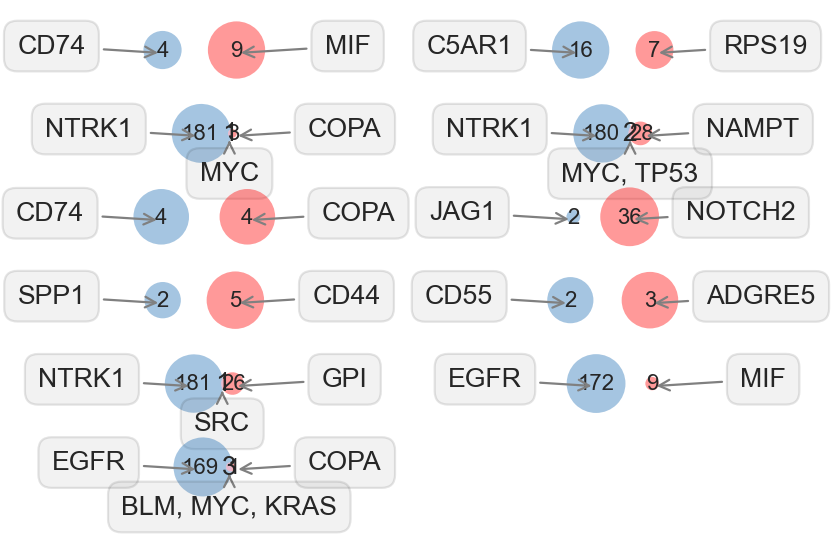

In [68]:
from matplotlib_venn import venn2
from matplotlib.cbook import flatten
from matplotlib import pyplot as plt
import numpy as np
figure, axes = plt.subplots(len(list(set(MT_res1) & set(PT_res1)))//2+1,2, figsize=(6,4))

def find_sl_sl(gene1,gene2):
    sl_test1=SL_pair.loc[(SL_pair['gene1']==gene1) | (SL_pair['gene2']==gene1)]
    sl_t1=list(set(sl_test1['gene1'].tolist()+sl_test1['gene2'].tolist()))

    sl_test2=SL_pair.loc[(SL_pair['gene1']==gene2) | (SL_pair['gene2']==gene2)]
    sl_t2=list(set(sl_test2['gene1'].tolist()+sl_test2['gene2'].tolist()))

    return sl_t1,sl_t2

for a,i in zip(flatten(axes),list(set(MT_res1) & set(PT_res1))):
    gene1,gene2=i.split('_')[0],i.split('_')[1]
    sl_t1,sl_t2=find_sl_sl(gene1,gene2)
    v=venn2(subsets=[set(sl_t1),set(sl_t2)],
      set_labels=('',''),
      set_colors=('#206FB4',dv_colors[1]),ax=a,
       normalize_to=1.0,)
    v.get_label_by_id('10').set_fontsize(10)#1的大小设置为20
    v.get_label_by_id('01').set_fontsize(10)#1的大小设置为20
    #v.get_label_by_id('11').set_fontsize(12)#1的大小设置为20
    if v.get_label_by_id('11')!=None:
        v.get_label_by_id('11').set_fontsize(12)#1的大小设置为20
        all_gene=list(set(sl_t1) & set(sl_t2))
        a.annotate(str(all_gene).replace(',',',').replace("'",'').replace('[','').replace(']',''), xy=v.get_label_by_id('11').get_position() - np.array([0, 0.05]), xytext=(0,-20),
             ha='center', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),
             arrowprops=dict(arrowstyle='->', color='gray'),size=12)
    for t in v.set_labels: 
        t.set_fontsize(12) 
    
    #a.annotate('gene1',xy=v.get_label_by_id('10').get_position())
    
    a.annotate(gene1, xy=v.get_label_by_id('10').get_position() - np.array([0, 0.05]), xytext=(-50,0),
             ha='center', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),
             arrowprops=dict(arrowstyle='->', color='gray'),size=12)
    
    a.annotate(gene2, xy=v.get_label_by_id('01').get_position() - np.array([0, 0.05]), xytext=(50,0),
             ha='center', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),
             arrowprops=dict(arrowstyle='->', color='gray'),size=12)
axes[5,1].axis('off')

plt.savefig("result/MT_PT_venn1.png",dpi=300,bbox_inches = 'tight')



# KEGG and Gene Ontology

In [69]:
gp_list=[]
for i in list(set(MT_res1) & set(PT_res1)):
    gp_list.append(i.split('_')[0])
    gp_list.append(i.split('_')[1])
#[i.split('_') for i in list(set(MT_res1) & set(PT_res1))]
list(set(gp_list))

['COPA',
 'C5AR1',
 'EGFR',
 'CD74',
 'RPS19',
 'JAG1',
 'ADGRE5',
 'GPI',
 'NAMPT',
 'SPP1',
 'CD44',
 'CD55',
 'NOTCH2',
 'NTRK1',
 'MIF']

In [564]:
import gseapy as gp
enr = gp.enrichr(gene_list=list(set(gp_list)),
				 gene_sets='KEGG_2019_Human',
				 organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
				 description='sl_kegg',
				 outdir='result/SL_KEGG',
				 # no_plot=True,
				 cutoff=0.5 # test dataset, use lower value from range(0,1)
				)
#subp=dotplot(enr.res2d, title=description,cmap='seismic')
#print(subp)
enr.res2d.head()

/Users/fernandozeng/miniforge3/envs/bio/lib/python3.8/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)


Gene_set                                 Term Overlap   P-value  \
0  KEGG_2019_Human       Human papillomavirus infection   4/330  0.000086   
1  KEGG_2019_Human                        Breast cancer   3/147  0.000166   
2  KEGG_2019_Human                   Pathways in cancer   4/530  0.000527   
3  KEGG_2019_Human              Notch signaling pathway    2/48  0.000581   
4  KEGG_2019_Human  Central carbon metabolism in cancer    2/65  0.001063   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0          0.005972            0                     0   21.928611   
1          0.005972            0                     0   34.446181   
2          0.010449            0                     0   13.452471   
3          0.010449            0                     0   66.685619   
4          0.015158            0                     0   48.649573   

   Combined Score                   Genes  
0      205.267120   NOTCH2;JAG1;SPP1;EGFR  
1      299.824681        NOTCH2;JAG1;EGFR  
2      101.533052  NOTCH2;NTRK1;JAG1;EGFR  
3      496.912903             NOTCH2;JAG1  
4      333.104192              NTRK1;EGFR

In [565]:
kegg_result_ad=enr.res2d[enr.res2d['Adjusted P-value']<0.05]
kegg_result_ad['logp']=-np.log(kegg_result_ad['Adjusted P-value'])
kegg_result_ad['logc']=np.log(kegg_result_ad['Combined Score'])
kegg_result_ad['num']=[int(i.split('/')[0]) for i in kegg_result_ad['Overlap']]

/var/folders/4m/2xw3_2s503s9r616083n7w440000gn/T/ipykernel_94793/1565130830.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kegg_result_ad['logp']=-np.log(kegg_result_ad['Adjusted P-value'])
/var/folders/4m/2xw3_2s503s9r616083n7w440000gn/T/ipykernel_94793/1565130830.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kegg_result_ad['logc']=np.log(kegg_result_ad['Combined Score'])
/var/folders/4m/2xw3_2s503s9r616083n7w440000gn/T/ipykernel_94793/1565130830.py:4: SettingWithCopyWarning: 
A value is trying 

In [566]:
def plot_text_set(text):
  if len(text)>10:
    t=text.split(' ')
    n=0
    res=''
    for i in t:
      if n==0:
        res=i 
      else:
        res=res+'\n'+i
      n+=1
    return res
  else:
    return text

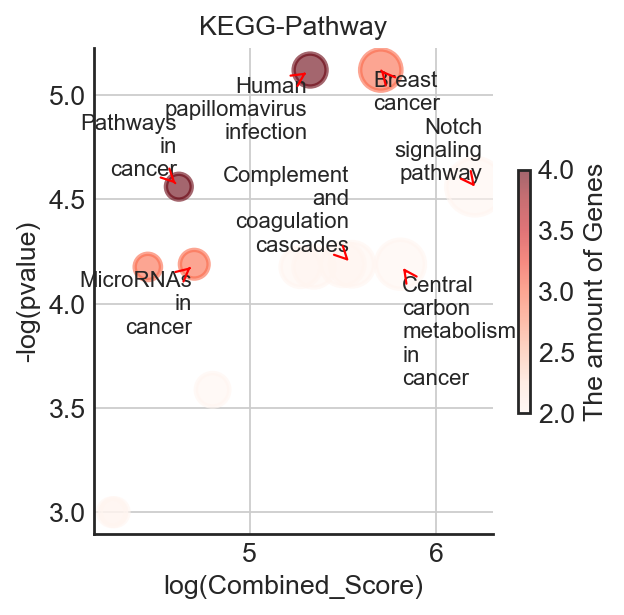

In [575]:
from adjustText import adjust_text
pp=plt.figure(figsize=(4,4))
#用ax控制图片
ax=pp.add_subplot(1,1,1)

plt.scatter(kegg_result_ad['logc'],kegg_result_ad['logp'],
      s=kegg_result_ad['Odds Ratio']*10,c=kegg_result_ad['num'],cmap='Reds',alpha=0.6,linewidth=2,)

test=kegg_result_ad['Term'].values
texts=[plt.text(kegg_result_ad[kegg_result_ad['Term']==i]['logc'].values[0], kegg_result_ad[kegg_result_ad['Term']==i]['logp'].values[0],
        plot_text_set(i)
        ,fontdict={'size':10}) for i in test[:7]]

adjust_text(texts,only_move={'text': 'xy'},arrowprops=dict(arrowstyle='->', color='red'),)


#plt.annotate(me_result.index[0], xy=(me_result['Impact'][0],me_result['-log10(p)'][0]), xytext=(0.2,2),
#bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.5),arrowprops=dict(arrowstyle='-',color='black'),size=15)

#plt.annotate(me_result.index[1], xy=(me_result['Impact'][1],me_result['-log10(p)'][1]), xytext=(0.2,1.5),
#bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.5),arrowprops=dict(arrowstyle='-',color='black'),size=15)

#plt.annotate(me_result.index[2], xy=(me_result['Impact'][2],me_result['-log10(p)'][2]), xytext=(0.2,1),
#bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.5),arrowprops=dict(arrowstyle='-',color='black'),size=15)

#设置横纵坐标轴字体
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
#设置图注
#plt.legend(loc='center right', bbox_to_anchor=(0, -.5), ncol=3,fontsize=12)
#设置横纵标题
plt.ylabel('-log(pvalue)',fontsize=12)                   
plt.xlabel('log(Combined_Score)',fontsize=12)
plt.title('KEGG-Pathway',fontsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
#ax.spines['bottom'].set_linewidth(2);###设置底部坐标轴的粗细
#ax.spines['left'].set_linewidth(2);####设置左边坐标轴的粗细
#ax.spines['right'].set_linewidth(2);###设置右边坐标轴的粗细
#ax.spines['top'].set_linewidth(2);####设置上部坐标轴的粗细

cb=plt.colorbar(label="The amount of Genes",shrink=0.5) 
cb.ax.tick_params(labelsize=12)
#plt.xticks(fontsize=12)
plt.grid(None)
cb.set_label('The amount of Genes',fontdict={'size':12})
#plt.savefig("kegg_ad.png",dpi=300,bbox_inches = 'tight')
plt.savefig("result/SL_KEGG.png",dpi=300,bbox_inches = 'tight')


In [584]:
import gseapy as gp
enr = gp.enrichr(gene_list=list(set(gp_list)),
				 gene_sets='GO_Biological_Process_2021',
				 organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
				 description='sl_bio',
				 outdir='result/SL_BIO',
				 # no_plot=True,
				 cutoff=0.5 # test dataset, use lower value from range(0,1)
				)
#subp=dotplot(enr.res2d, title=description,cmap='seismic')
#print(subp)
enr.res2d.head()

/Users/fernandozeng/miniforge3/envs/bio/lib/python3.8/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)


Gene_set  \
0  GO_Biological_Process_2021   
1  GO_Biological_Process_2021   
2  GO_Biological_Process_2021   
3  GO_Biological_Process_2021   
4  GO_Biological_Process_2021   

                                                Term Overlap       P-value  \
0  positive regulation of ERK1 and ERK2 cascade (...   7/172  1.868477e-11   
1   regulation of ERK1 and ERK2 cascade (GO:0070372)   7/238  1.835548e-10   
2   positive regulation of MAPK cascade (GO:0043410)   7/274  4.915681e-10   
3  negative regulation of intrinsic apoptotic sig...    3/13  9.716159e-08   
4  negative regulation of DNA damage response, si...    3/14  1.236050e-07   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0      8.912635e-09            0                     0  105.106061   
1      4.377782e-08            0                     0   74.825758   
2      7.815933e-08            0                     0   64.618914   
3      9.826597e-06            0                     0  499.375000   
4      9.826597e-06            0                     0  453.954545   

   Combined Score                                  Genes  
0     2596.467847  NOTCH2;NTRK1;CD74;C5AR1;MIF;EGFR;CD44  
1     1677.481827  NOTCH2;NTRK1;CD74;C5AR1;MIF;EGFR;CD44  
2     1385.004364  NOTCH2;NTRK1;CD74;C5AR1;MIF;EGFR;CD44  
3     8063.353377                          CD74;MIF;CD44  
4     7220.680378                          CD74;MIF;CD44

In [589]:
kegg_result_ad=enr.res2d[enr.res2d['Adjusted P-value']<0.01]
kegg_result_ad['logp']=-np.log(kegg_result_ad['Adjusted P-value'])
kegg_result_ad['logc']=np.log(kegg_result_ad['Combined Score'])
kegg_result_ad['num']=[int(i.split('/')[0]) for i in kegg_result_ad['Overlap']]

/var/folders/4m/2xw3_2s503s9r616083n7w440000gn/T/ipykernel_94793/416450625.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kegg_result_ad['logp']=-np.log(kegg_result_ad['Adjusted P-value'])
/var/folders/4m/2xw3_2s503s9r616083n7w440000gn/T/ipykernel_94793/416450625.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kegg_result_ad['logc']=np.log(kegg_result_ad['Combined Score'])
/var/folders/4m/2xw3_2s503s9r616083n7w440000gn/T/ipykernel_94793/416450625.py:4: SettingWithCopyWarning: 
A value is trying to 

In [590]:
def plot_text_set(text):
  if len(text)>10:
    t=text.split(' ')
    n=0
    res=''
    for i in t:
      if n==0:
        res=i 
      else:
        res=res+'\n'+i
      n+=1
    return res
  else:
    return text

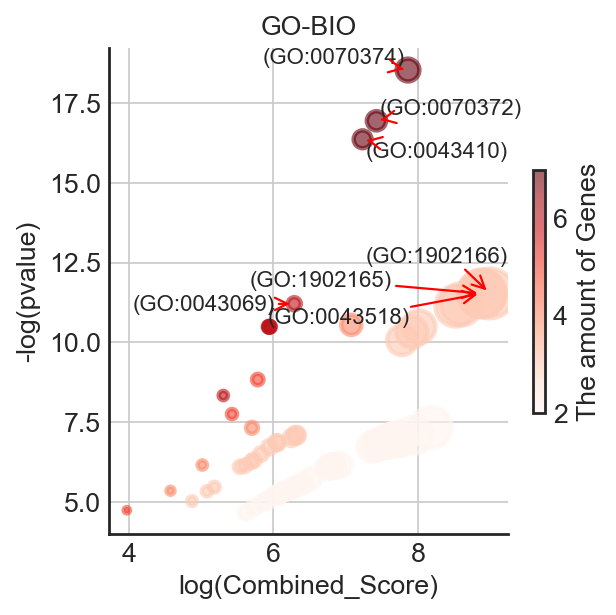

In [592]:
from adjustText import adjust_text
pp=plt.figure(figsize=(4,4))
#用ax控制图片
ax=pp.add_subplot(1,1,1)

plt.scatter(kegg_result_ad['logc'],kegg_result_ad['logp'],
      s=kegg_result_ad['Odds Ratio'],c=kegg_result_ad['num'],cmap='Reds',alpha=0.6,linewidth=2,)

test=kegg_result_ad['Term'].values
texts=[plt.text(kegg_result_ad[kegg_result_ad['Term']==i]['logc'].values[0], kegg_result_ad[kegg_result_ad['Term']==i]['logp'].values[0],
        '('+plot_text_set(i).split('(')[1]
        ,fontdict={'size':10}) for i in test[:7]]

adjust_text(texts,only_move={'text': 'xy'},arrowprops=dict(arrowstyle='->', color='red'),)


#plt.annotate(me_result.index[0], xy=(me_result['Impact'][0],me_result['-log10(p)'][0]), xytext=(0.2,2),
#bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.5),arrowprops=dict(arrowstyle='-',color='black'),size=15)

#plt.annotate(me_result.index[1], xy=(me_result['Impact'][1],me_result['-log10(p)'][1]), xytext=(0.2,1.5),
#bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.5),arrowprops=dict(arrowstyle='-',color='black'),size=15)

#plt.annotate(me_result.index[2], xy=(me_result['Impact'][2],me_result['-log10(p)'][2]), xytext=(0.2,1),
#bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.5),arrowprops=dict(arrowstyle='-',color='black'),size=15)

#设置横纵坐标轴字体
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
#设置图注
#plt.legend(loc='center right', bbox_to_anchor=(0, -.5), ncol=3,fontsize=12)
#设置横纵标题
plt.ylabel('-log(pvalue)',fontsize=12)                   
plt.xlabel('log(Combined_Score)',fontsize=12)
plt.title('GO-BIO',fontsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
#ax.spines['bottom'].set_linewidth(2);###设置底部坐标轴的粗细
#ax.spines['left'].set_linewidth(2);####设置左边坐标轴的粗细
#ax.spines['right'].set_linewidth(2);###设置右边坐标轴的粗细
#ax.spines['top'].set_linewidth(2);####设置上部坐标轴的粗细

cb=plt.colorbar(label="The amount of Genes",shrink=0.5) 
cb.ax.tick_params(labelsize=12)
#plt.xticks(fontsize=12)
plt.grid(None)
cb.set_label('The amount of Genes',fontdict={'size':12})
#plt.savefig("kegg_ad.png",dpi=300,bbox_inches = 'tight')
plt.savefig("result/SL_BIO.png",dpi=300,bbox_inches = 'tight')
